In [94]:
import ray
from ray import tune
import os
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import  seaborn as sns
import learning_lidar.utils.global_settings as gs
import matplotlib as mpl
sns.set_palette(sns.color_palette("tab10"))

plt.rcParams['figure.dpi'] = gs.FIGURE_DPI
plt.rcParams['savefig.dpi'] = gs.SAVEFIG_DPI

sns.set_theme()
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [95]:
def extract_powers(row, in_channels):
    powers = eval(row['powers']) if type(row['powers'])==str else None
    pow_y = np.array(powers[1])[0] if type(powers)==tuple else None
    pow_x = np.array(powers[0]) if type(powers)==tuple else None
    pow_xi = np.zeros(in_channels)
    if type(pow_x)==np.ndarray:
        for chan in range(in_channels):
            pow_xi[chan] = pow_x[chan] if  (len(pow_x)>=chan+1) else None
    else:
        for chan in range(in_channels):
            pow_xi[chan] = None
    return [pow_y,*pow_xi]

In [96]:
base_folder = os.path.dirname(os.path.dirname(os.path.abspath(os.curdir)))
results_folder = os.path.join(base_folder, 'results')

# postprocessing LCNET results from jason state files saved in  `runs_board.xlsx`

In [97]:
runs_df = pd.read_excel(os.path.join(results_folder,'runs_board.xlsx'))
for idx,row in runs_df.iterrows():
    #row = runs_df.iloc[idx]
    try:
        state_fname = glob.glob(os.path.join( row.experiment_folder,r'experiment_state*.json'))[0]
        analysis = tune.ExperimentAnalysis(state_fname)
        ignore_MARELoss = "MARELoss" in [row.field_to_ignore]
        analysis.default_metric = "MARELoss" if ignore_MARELoss else "MARELoss"
        analysis.default_mode="min"
        results_df = analysis.dataframe(metric="MARELoss", mode="min",)

        # update fields:
        if ignore_MARELoss:
            results_df["MARELoss"]=None

        # rename column names:
        cols = results_df.columns.values.tolist()
        new_cols = [col.replace('config/',"") for col in cols]
        dict_cols ={}
        for col,new_col in zip(cols, new_cols):
            dict_cols.update({col:new_col})
        results_df = results_df.rename(columns= dict_cols)

        # update power values:
        len_pow = len(results_df[results_df.use_power==True])
        len_no_pow = len(results_df[results_df.use_power==False])
        len_pows = len(results_df[results_df.use_power !=False])
        if len_no_pow>0:
            results_df.loc[results_df[results_df.use_power==False].index,'powers']= ''
        if len_pows!=len_pow:
            results_df.loc[results_df[results_df.use_power!=False].index,'powers']=results_df.use_power
            results_df.loc[results_df[results_df.use_power!=False].index,'use_power']=True
        else:
            results_df.loc[results_df[results_df.use_power==True].index,'powers']= '([0.5,0.5],[0.5])'

        # Update Notes
        note = row['note']
        results_df['note']= note if type(note)==str else 'ok'

        # drop irrelevant columns:
        drop_cols = [ 'time_this_iter_s', 'should_checkpoint', 'done',
                   'timesteps_total', 'episodes_total',
                   'experiment_id',  'timestamp',  'pid', 'hostname',
                   'node_ip', 'time_since_restore', 'timesteps_since_restore',
                   'iterations_since_restore']
        results_df.drop(columns=drop_cols,inplace=True)


        # reorganize columns:
        new_order = ['trial_id', 'date','time_total_s','training_iteration',
                     'loss', 'MARELoss',
                     'bsize', 'dfilter', 'dnorm','fc_size', 'hsizes', 'lr',
                     'ltype', 'source', 'use_bg', 'use_power','powers','note','logdir']
        results_df = results_df.reindex(columns=new_order)

        # keep index trial (especially for cases when trails are ignored)
        #results_df['idx']=results_df.index
        #new_cols = ['idx']
        #new_cols.extend(cols)
        #results_df = results_df.reindex(columns=new_cols)

        # remove irrelevant trials (e.g. when dnorm had wrong calculation)
        if row.trial_to_ignore is not np.nan:
            key,cond = eval(row.trial_to_ignore)
            results_df.drop(index=results_df[results_df[key]==cond].index,inplace=True)

        # save csv
        results_csv = os.path.join(analysis._experiment_dir, f'experiment_results.csv')
        results_df.to_csv(results_csv, index=False)

        # update csv path in main runs_board
        runs_df.loc[idx,'results_csv']=results_csv
        print(results_csv)
        #runs_df.loc[idx,'best_trial']=analysis.best_trial
        #runs_df.loc[idx,'best_config']=analysis.best_config
        #runs_df.loc[idx,'best_logger']=analysis.best_logdir
        #runs_df.loc[idx,'best_checkpoint']=analysis.best_checkpoint
        #runs_df.loc[idx,'best_result']=analysis.best_result
    except:
        continue
# TODO: save runs_df with results_csv paths

No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
Couldn't read config from 5 paths
No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of s

C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-05-06_19-17-01\experiment_results.csv
C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-05-08_17-45-11\experiment_results.csv
C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-05-09_22-48-01\experiment_results.csv
C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-05-12_11-54-20\experiment_results.csv
C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-05-12_16-45-18\experiment_results.csv
C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-05-12_21-04-44\experiment_results.csv
C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-05-13_01-25-47\experiment_results.csv
C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-05-13_09-42-44\experiment_results.csv
C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-05-13_15-41-26\experiment_results.csv
C:\Users\addalin\Dropbox\Lidar\lidar_learning\results\main_2021-05-13_23-14-02\exp

In [98]:
paths = [row['results_csv'] for idx,row in runs_df.iterrows() if (row['include'] and type (row['results_csv'])==str)]
results_dfs=[pd.read_csv(path) for path in paths]
total_results = pd.concat(results_dfs,ignore_index=True)
#
total_results['fc_size'] = total_results.fc_size.apply(lambda x: eval(str(x))[0])
# update powers
in_channels = 3
res= total_results.apply(extract_powers,args=(in_channels,), axis=1, result_type='expand')
cols_powx = [f"pow_x{ind+1}" for ind in range(in_channels)]
res.rename( columns={0:'pow_y',1:cols_powx[0],2:cols_powx[1],3:cols_powx[2]},inplace=True)
total_results[res.columns.values] = res
total_results['powers'] = total_results.powers.apply(lambda x: eval(x) if type(x)==str else None)

analyse_results = total_results[total_results.training_iteration>=2]

In [99]:
total_results

,trial_id,date,time_total_s,training_iteration,loss,MARELoss,bsize,dfilter,dnorm,fc_size,...,source,use_bg,use_power,powers,note,logdir,pow_y,pow_x1,pow_x2,pow_x3
0,7d54c_00009,2021-05-07_02-30-01,2296.601451,4.0,41.415855,NaN,32,NaN,False,4,...,lidar,False,True,"([0.5, 0.5], [0.5])",zeroed samples,C:\Users\addalin\Dropbox\Lidar\lidar_learning\...,0.5,0.5,0.50,NaN
1,7d54c_00003,2021-05-06_22-28-03,2599.558585,4.0,31.290869,NaN,32,NaN,False,32,...,lidar,False,True,"([0.5, 0.5], [0.5])",zeroed samples,C:\Users\addalin\Dropbox\Lidar\lidar_learning\...,0.5,0.5,0.50,NaN
2,7d54c_00041,2021-05-08_00-15-13,683.551777,1.0,148.198227,NaN,32,NaN,False,4,...,signal,False,True,"([0.5, 0.5], [0.5])",zeroed samples,C:\Users\addalin\Dropbox\Lidar\lidar_learning\...,0.5,0.5,0.50,NaN
3,7d54c_00025,2021-05-07_13-12-22,2500.368573,4.0,32.670639,NaN,32,NaN,False,4,...,signal,False,True,"([0.5, 0.5], [0.5])",zeroed samples,C:\Users\addalin\Dropbox\Lidar\lidar_learning\...,0.5,0.5,0.50,NaN
4,7d54c_00033,2021-05-07_18-51-57,2372.483233,4.0,46.721329,NaN,32,NaN,False,4,...,signal,False,True,"([0.5, 0.5], [0.5])",zeroed samples,C:\Users\addalin\Dropbox\Lidar\lidar_learning\...,0.5,0.5,0.50,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,f63a1_00004,2021-05-20_13-48-40,419.900265,4.0,28.166536,0.171832,32,NaN,False,16,...,lidar,False,True,"([0.5, 0.5], [0.5])",ok,C:\Users\addalin\Dropbox\Lidar\lidar_learning\...,0.5,0.5,0.50,NaN
536,f63a1_00017,2021-05-20_15-31-03,466.693345,4.0,18.455317,0.116784,32,NaN,False,32,...,lidar,False,True,"([0.5, 0.25], [0.5])",ok,C:\Users\addalin\Dropbox\Lidar\lidar_learning\...,0.5,0.5,0.25,NaN
537,f63a1_00000,2021-05-20_13-17-35,698.519381,4.0,35.683067,0.219084,32,NaN,False,16,...,lidar,False,True,"([0.5, 0.5], [0.5])",ok,C:\Users\addalin\Dropbox\Lidar\lidar_learning\...,0.5,0.5,0.50,NaN
538,5586a_00001,2021-05-21_01-55-49,194.627063,1.0,38.232807,0.248124,32,NaN,False,32,...,lidar,range_corr,True,"([0.5, 0.5, 0.5], [0.5])",ok,C:\Users\addalin\Dropbox\Lidar\lidar_learning\...,0.5,0.5,0.50,0.5


## 1. Choosing Learning rate
1. X: range_corr(lidar), attbsc(molecular). Y:LC
> use_normalization = False
> use_power = True
> source = lidar

<ipython-input-100-4b5bb733bfa7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pow_lidar[pow_lidar.pow_x1==0.5][pow_lidar.pow_x2==0.5][np.isnan(pow_lidar.pow_x3)][pow_lidar.pow_y==0.5]
<ipython-input-100-4b5bb733bfa7>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pow_lidar[pow_lidar.pow_x1==0.5][pow_lidar.pow_x2==0.5][np.isnan(pow_lidar.pow_x3)][pow_lidar.pow_y==0.5]


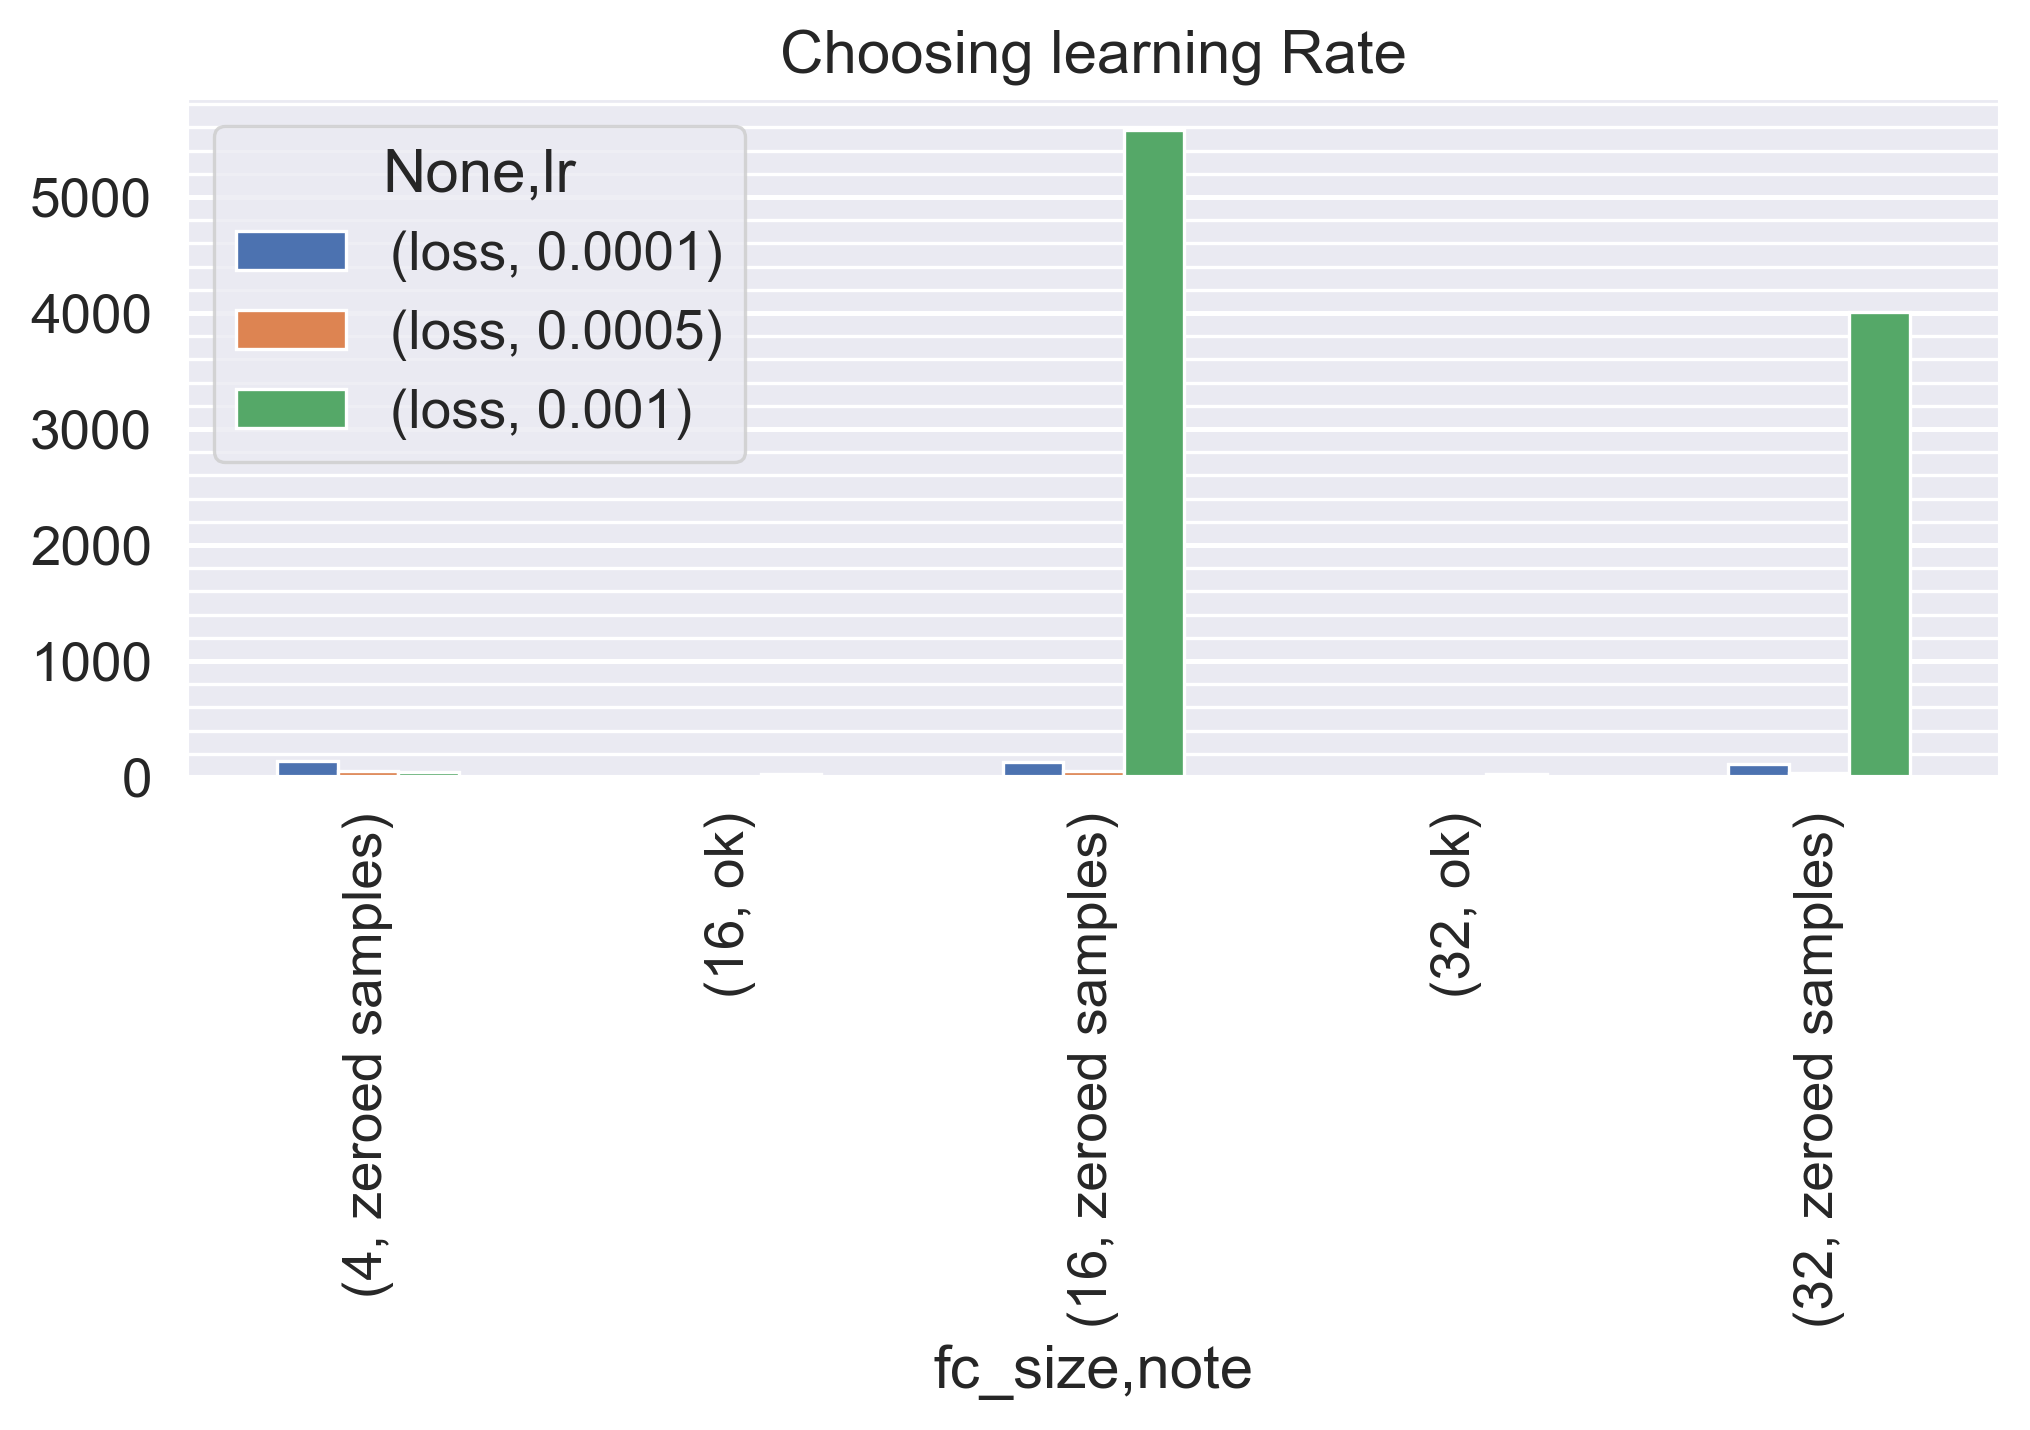

In [100]:
lidar_res = analyse_results[analyse_results.source=='lidar' ]
lidar_res = lidar_res[lidar_res.use_bg==False]
pow_lidar = lidar_res[(~lidar_res.dnorm & lidar_res.use_power ) ]
pow_lidar[pow_lidar.pow_x1==0.5][pow_lidar.pow_x2==0.5][np.isnan(pow_lidar.pow_x3)][pow_lidar.pow_y==0.5]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))
pd.pivot_table(pow_lidar,#[pow_lidar.note=='ok'],
               values=['loss'],
               columns= ['lr'],
               index=['fc_size','note'],
               aggfunc=np.mean).\
    plot(kind='bar',ax =ax, title='Choosing learning Rate')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()

## 2. FC vs. hidden sizes
1. X: range_corr(lidar), attbsc(molecular). Y:LC
> use_normalization = False
> use_power = True
> source = lidar
> lr = 0.001 or lr = 0.005

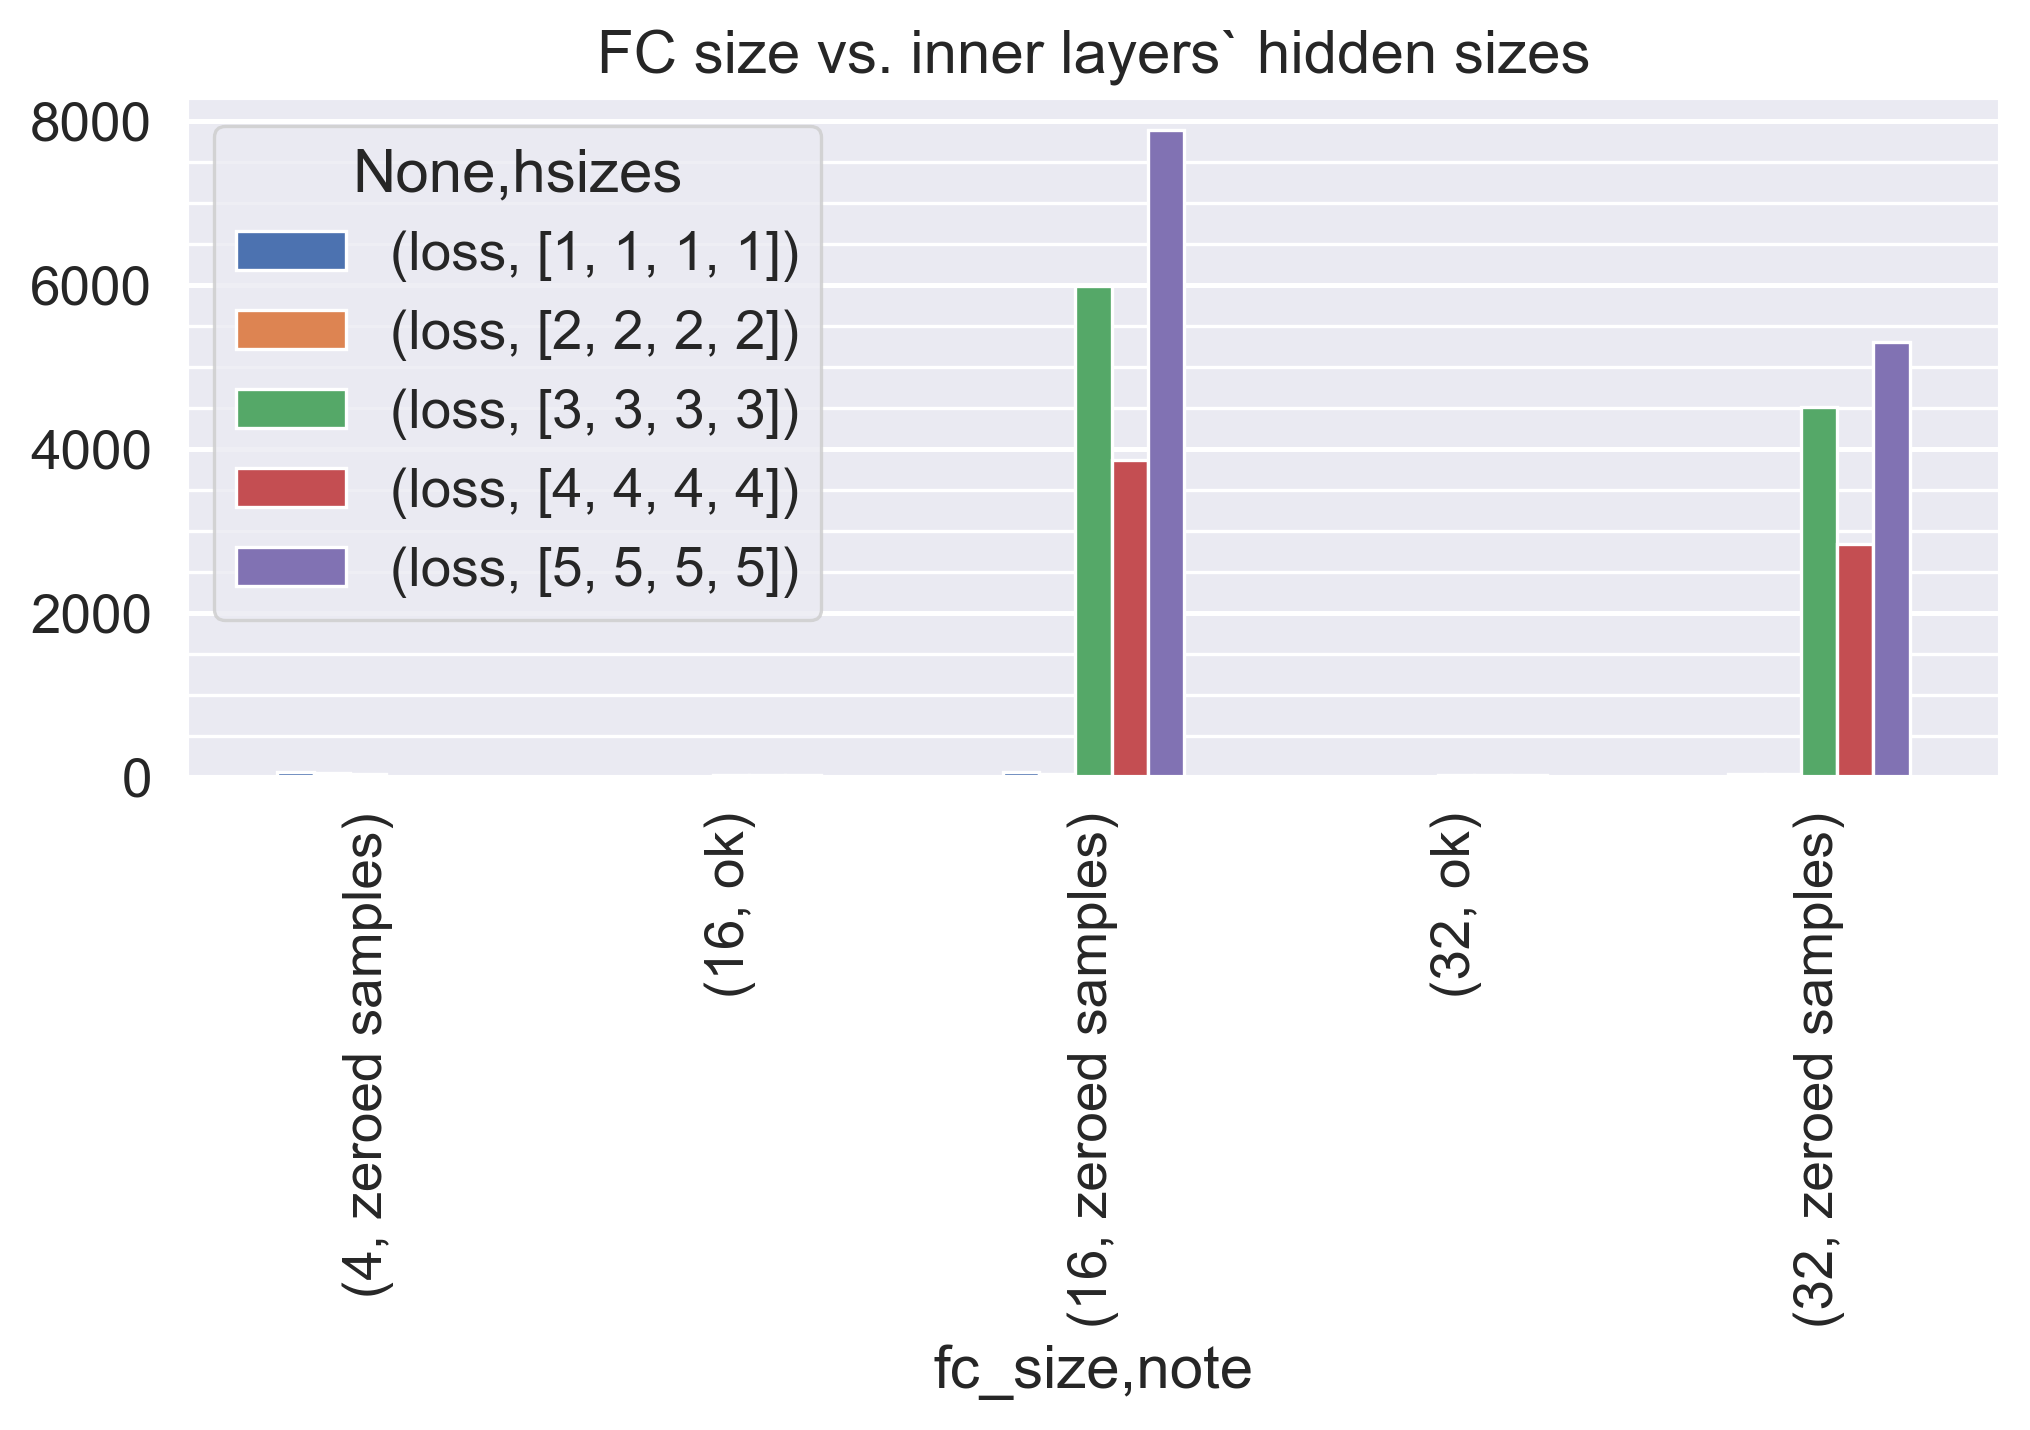

In [101]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))

pd.pivot_table(pow_lidar[pow_lidar.lr!=0.0001],
               values=['loss'],
               columns= ['hsizes'],
               index=['fc_size','note'],
               aggfunc=np.mean).\
    plot(kind='bar',ax =ax, title='FC size vs. inner layers` hidden sizes')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()

## 3. Normalization vs. Power transform
1. X: range_corr(lidar), attbsc(molecular). Y:LC
> use_power = False
> source = lidar

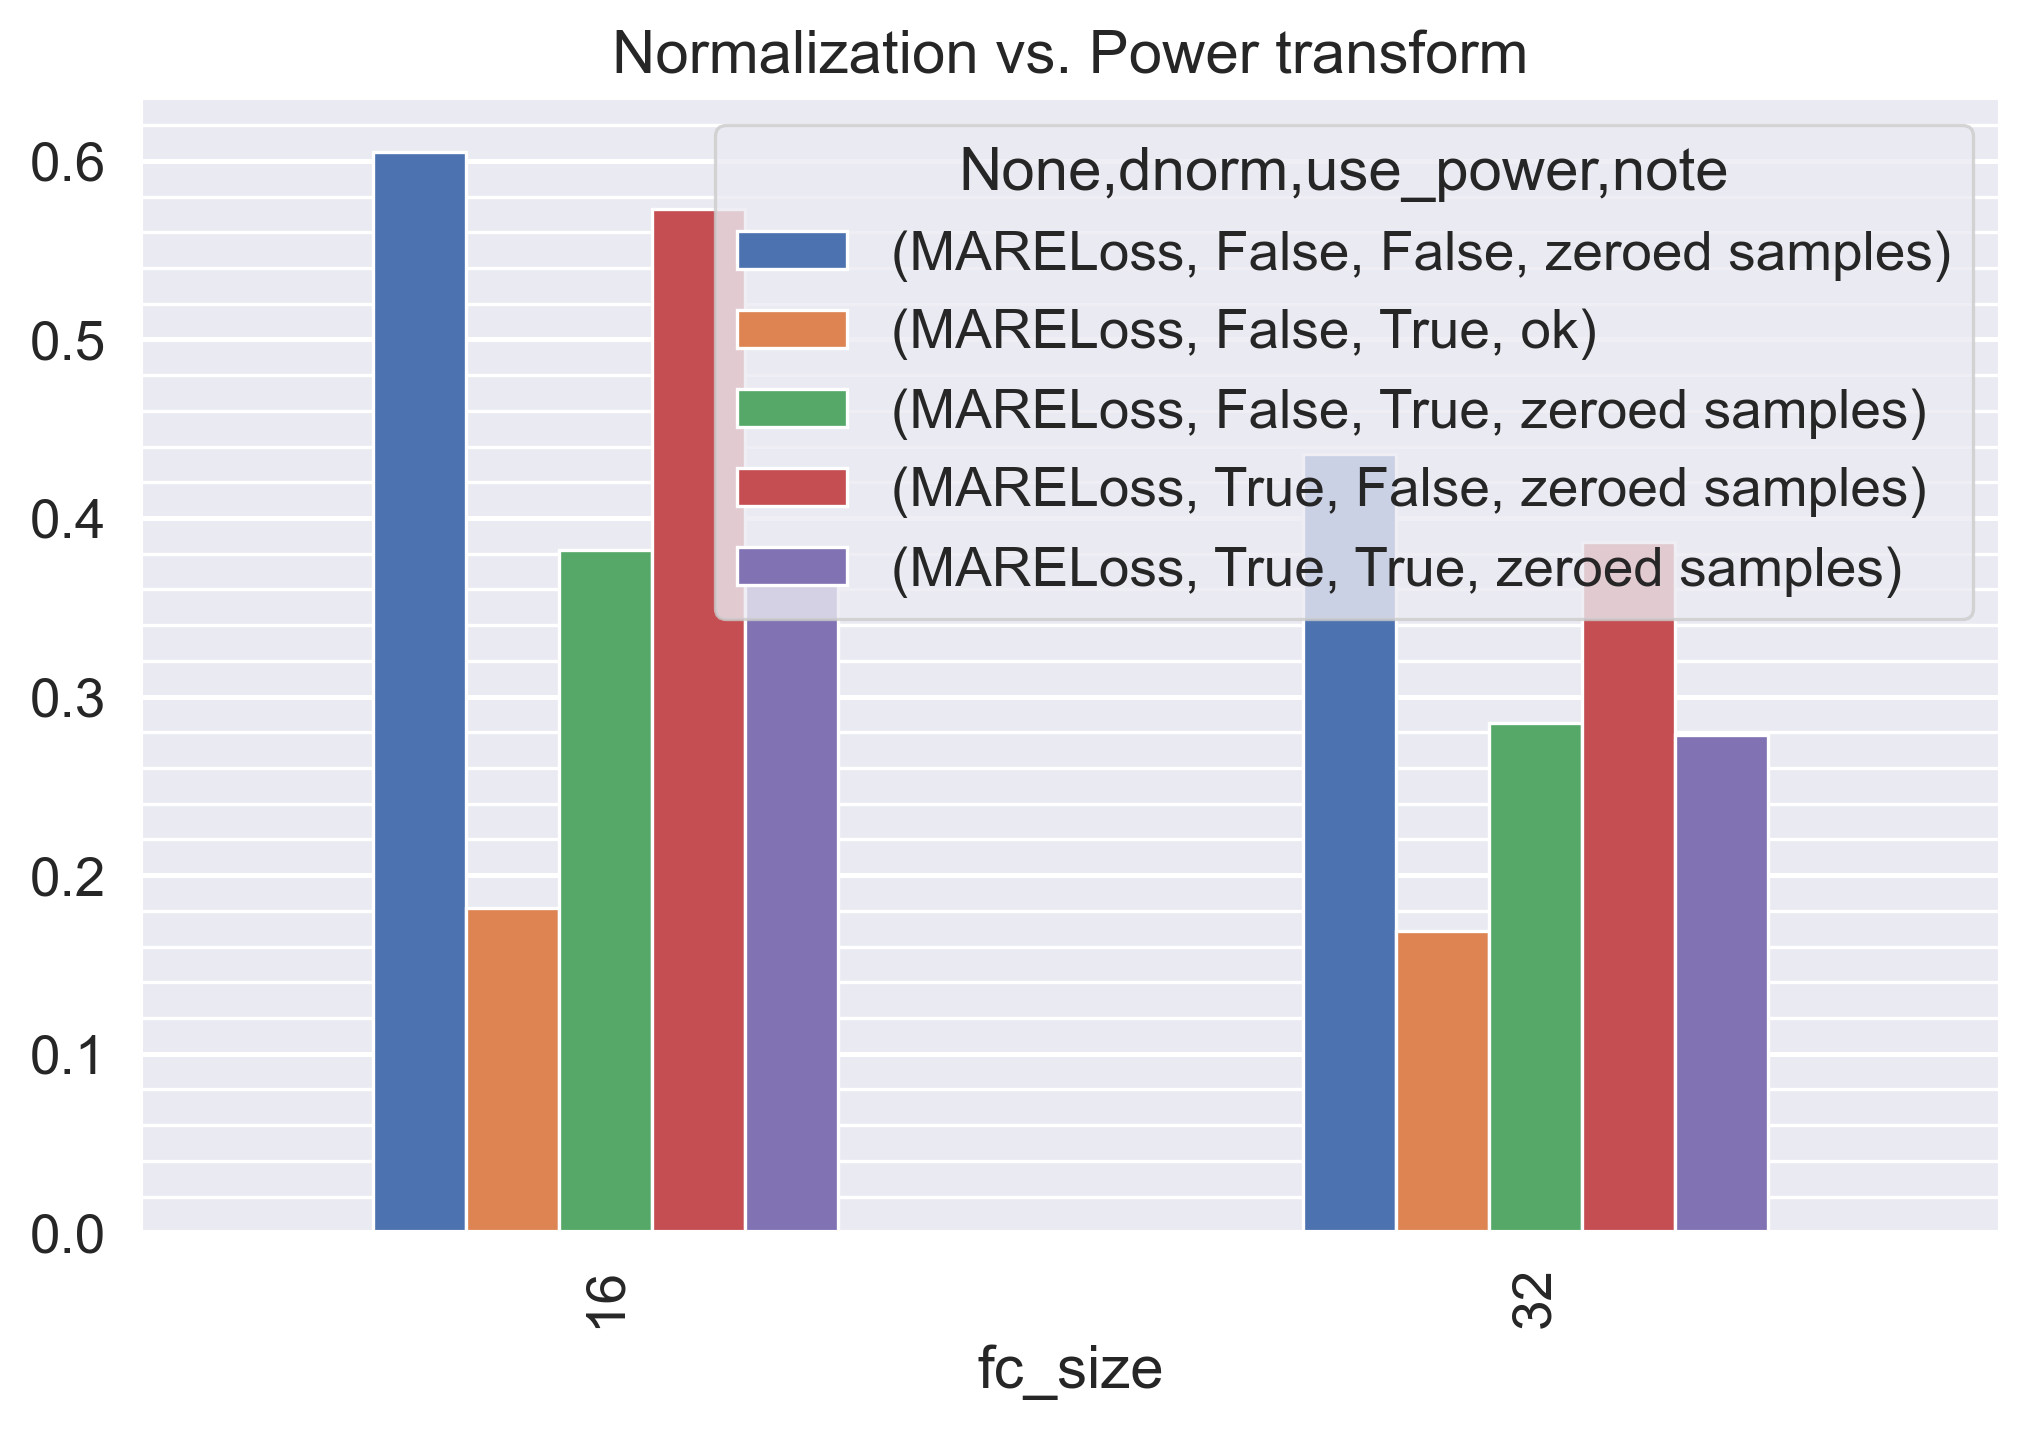

In [102]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))
pd.pivot_table(lidar_res,
               values=['MARELoss'],
               columns= ['dnorm','use_power','note'],
               index=['fc_size'],
               aggfunc=np.mean).\
    plot(kind='bar',ax =ax, title='Normalization vs. Power transform')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()

## 3. Type of Power transform
1. X: range_corr(lidar), attbsc(molecular). Y:LC
> source = lidar
> use_bg = False
> dnorm = False
> lr = 0.001

In [103]:
pow_lidar.use_power!=False

0      True
1      True
5      True
6      True
7      True
       ... 
533    True
534    True
535    True
536    True
537    True
Name: use_power, Length: 95, dtype: bool

<ipython-input-104-ac90dc79a0c4>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pow_lidar= pow_lidar[analyse_results.use_bg==False]


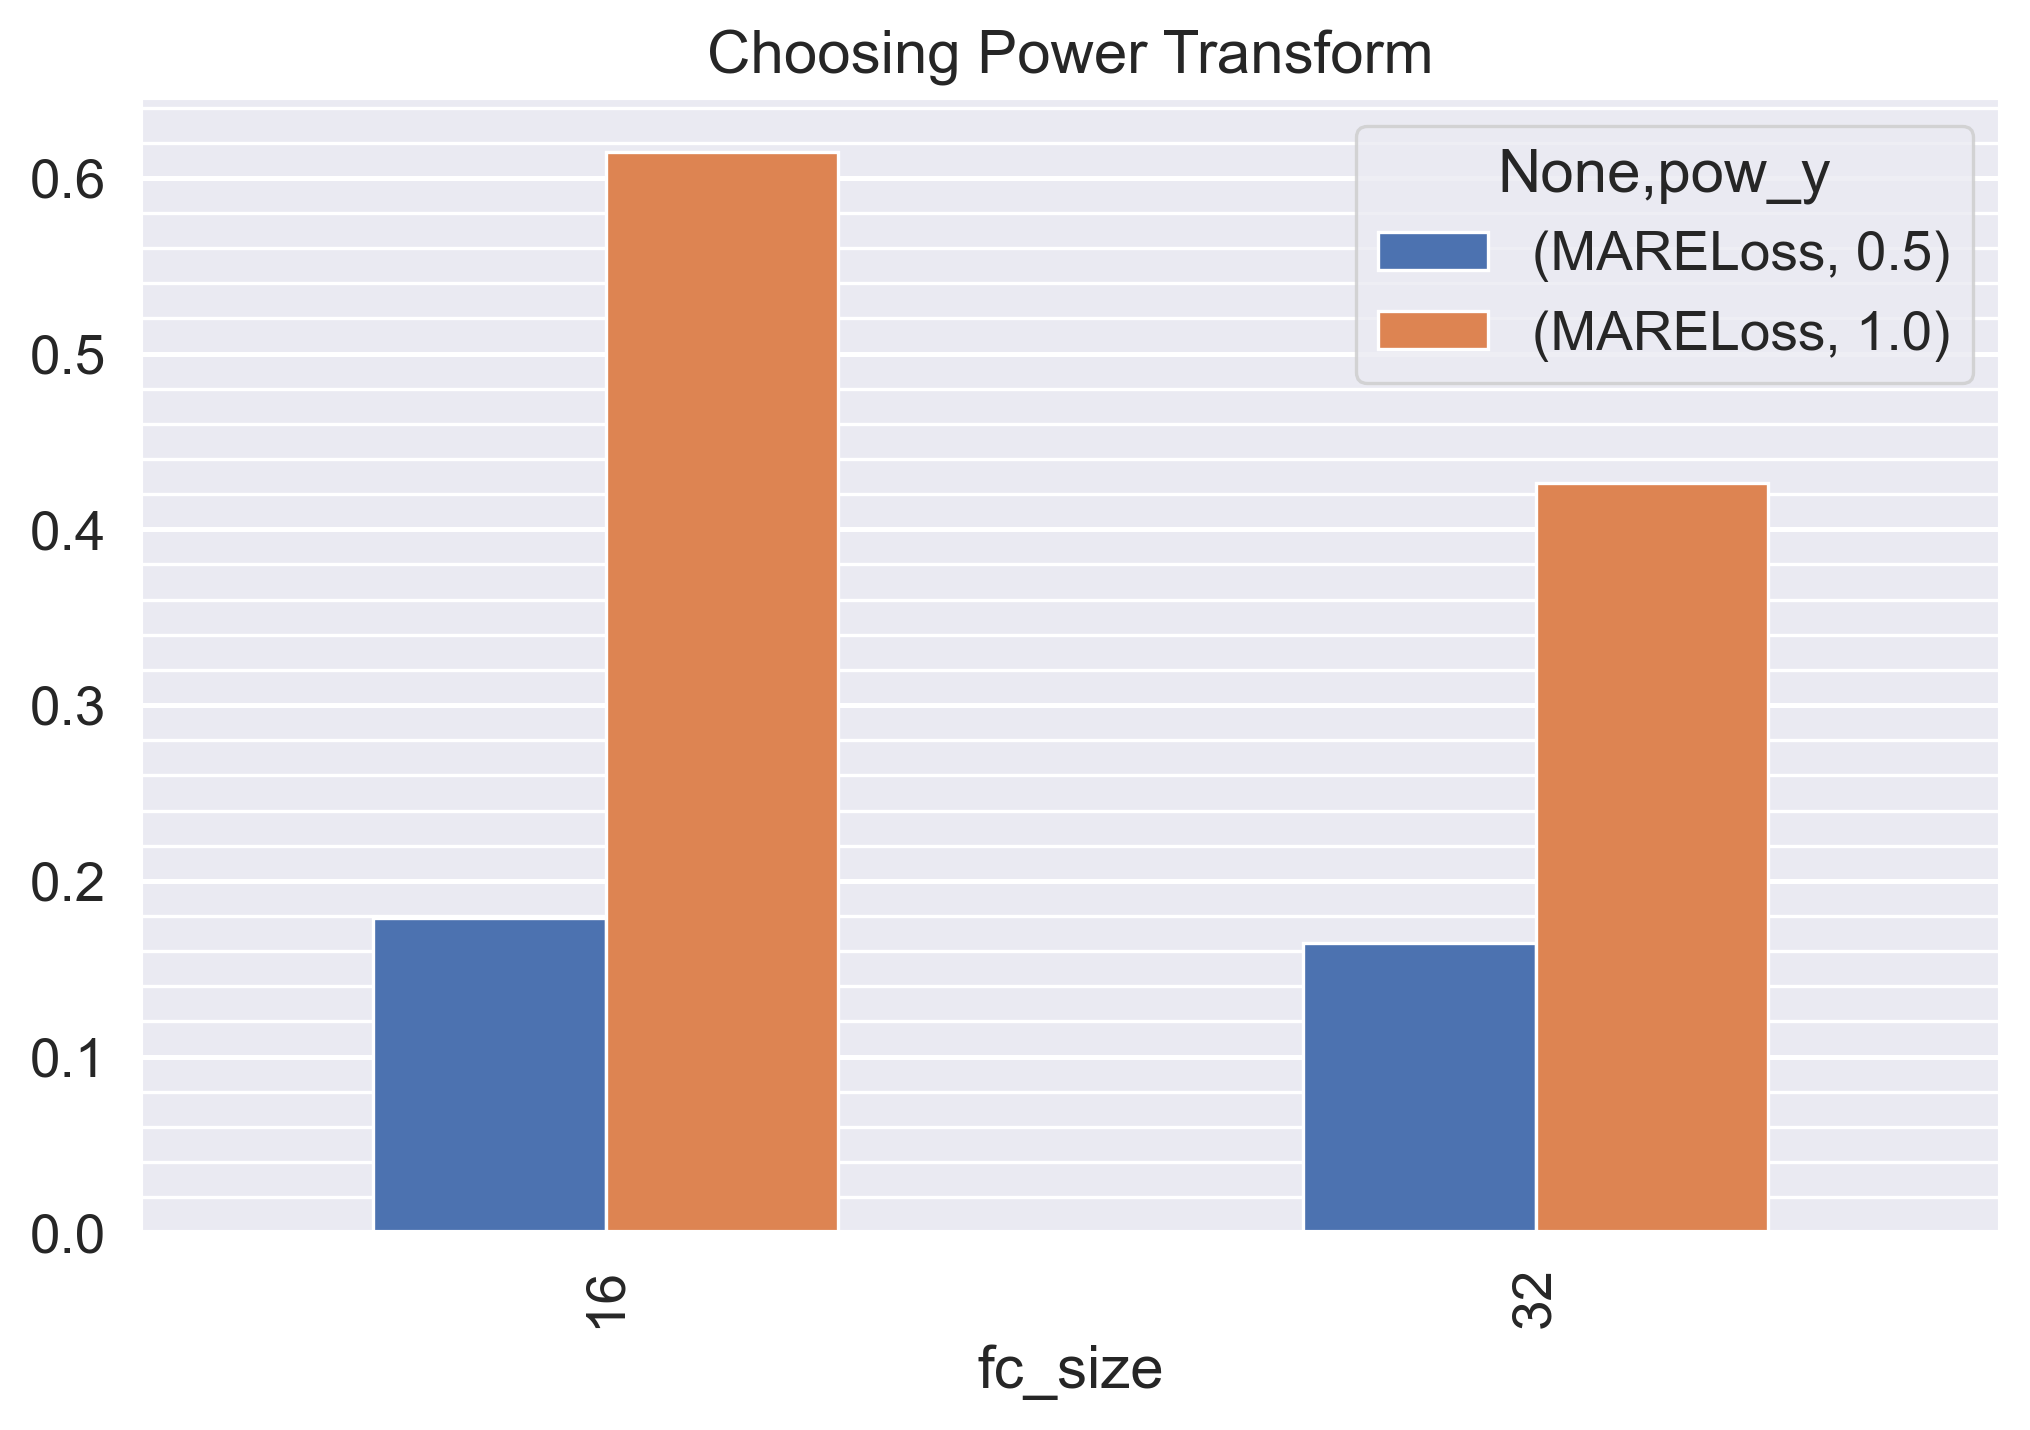

In [104]:
pow_lidar = analyse_results[analyse_results.source=='lidar']
pow_lidar= pow_lidar[~pow_lidar.dnorm]
pow_lidar= pow_lidar[analyse_results.use_bg==False]
pow_lidar= pow_lidar[pow_lidar.use_power]
pow_lidar = pow_lidar[pow_lidar.lr==0.001]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))
pd.pivot_table(pow_lidar,
               values=['MARELoss'],
               columns= ['pow_y' ],
               index=['fc_size'],
               aggfunc=np.mean).\
    plot(kind='bar',ax =ax, title='Choosing Power Transform')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()

<ipython-input-105-39056f691366>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(pow_lidar[pow_lidar['pow_y']==0.5][(pow_lidar['pow_x1']==0.5)],


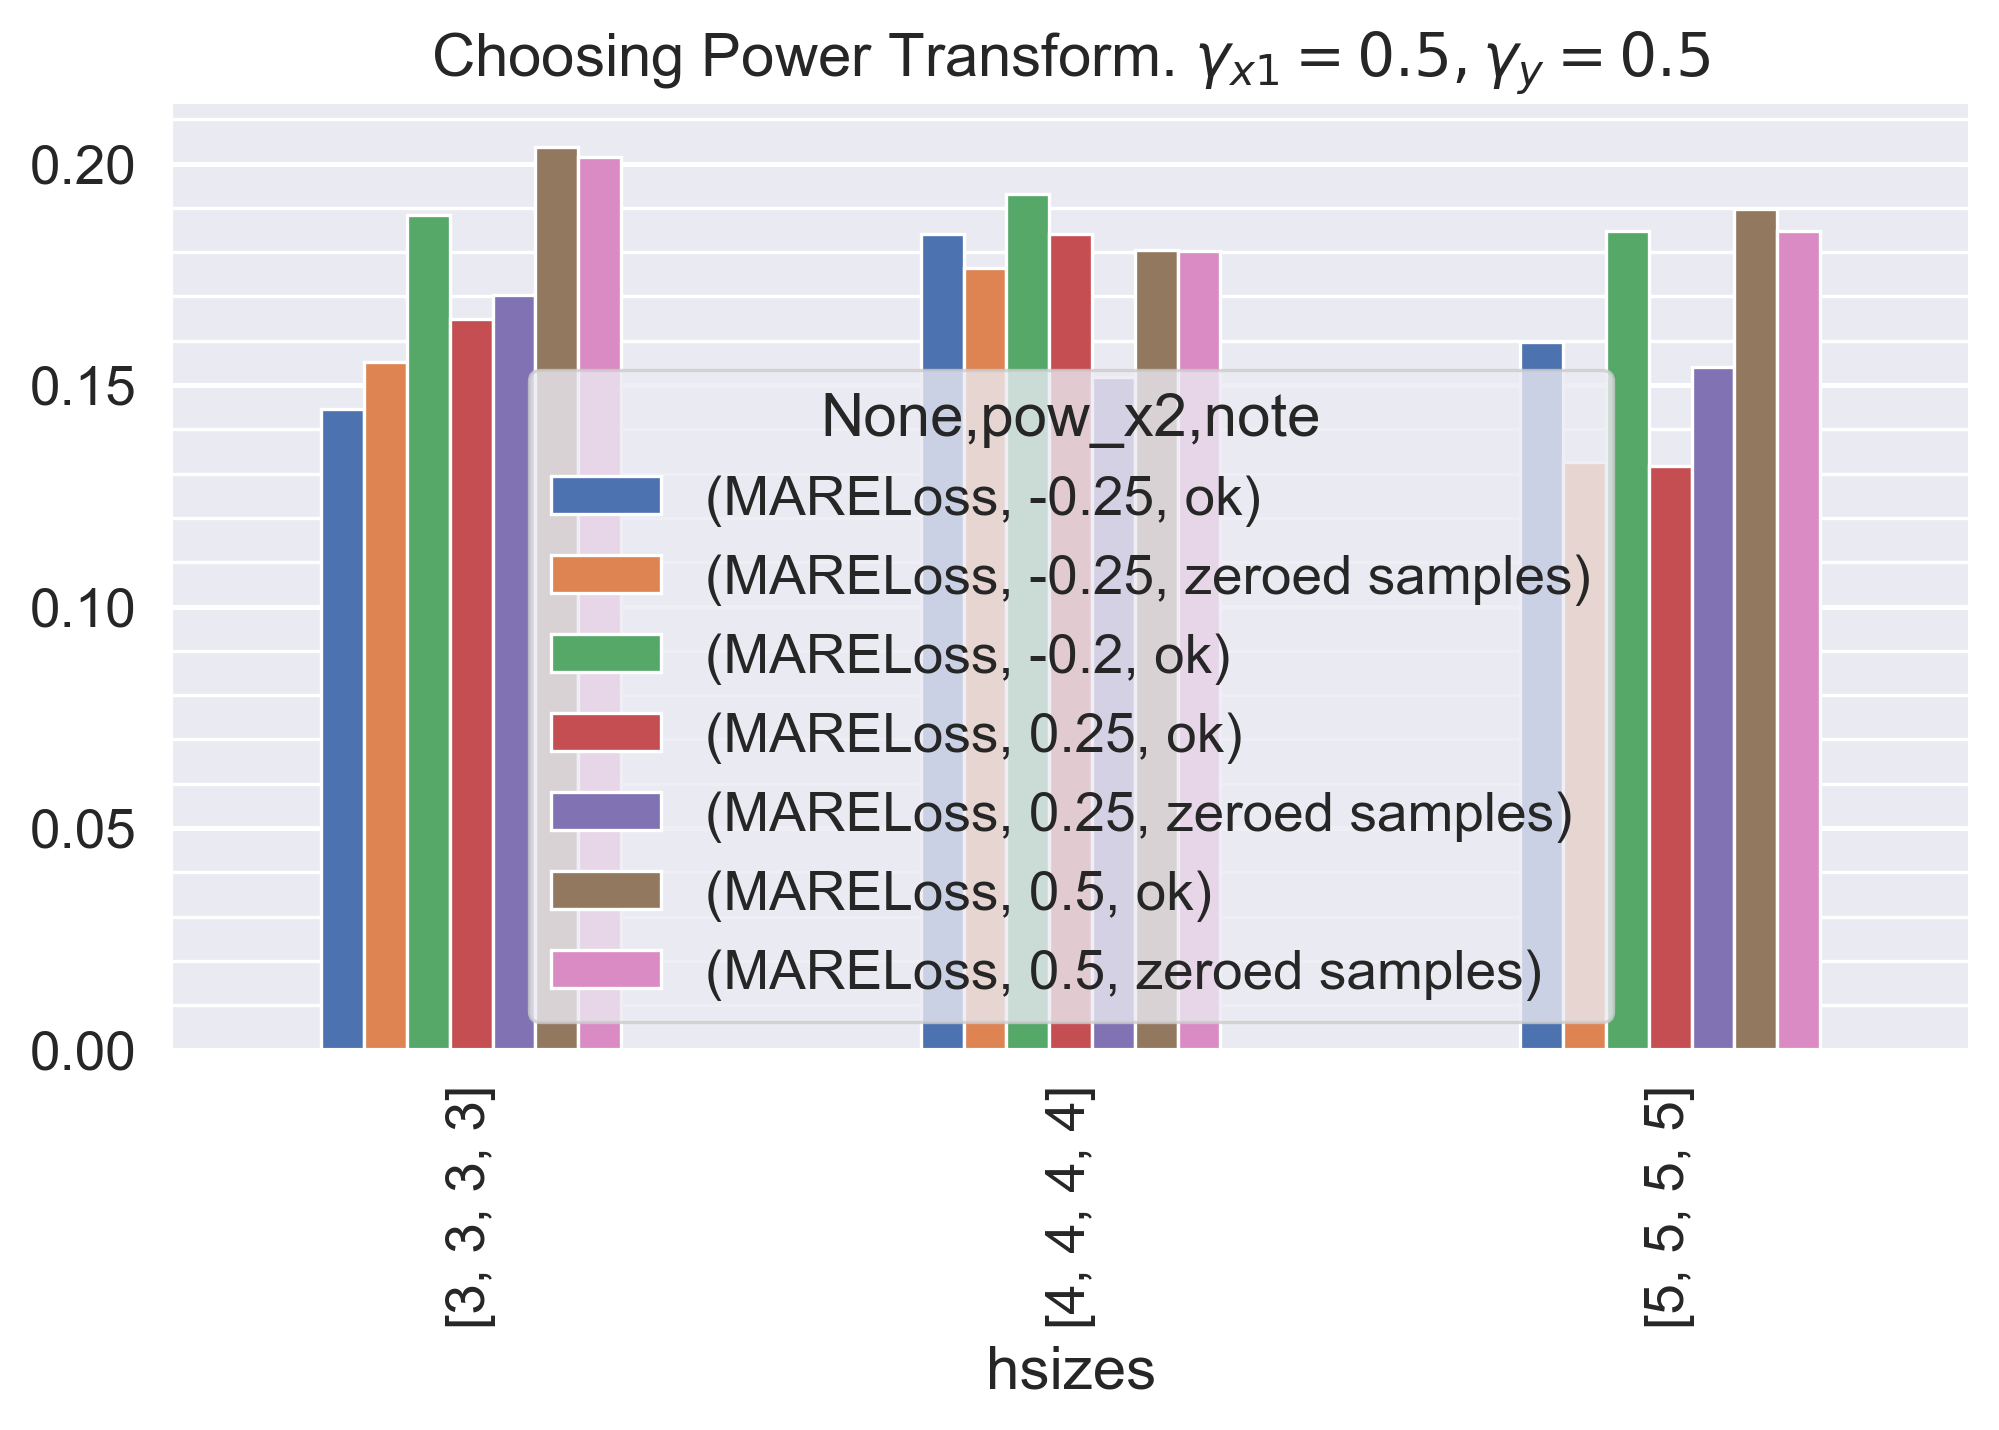

In [105]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))
pd.pivot_table(pow_lidar[pow_lidar['pow_y']==0.5][(pow_lidar['pow_x1']==0.5)],
               values=['MARELoss'],
               columns= ['pow_x2','note'],
               index=['hsizes'],
               aggfunc=np.mean).\
    plot(kind='bar',ax =ax, title='Choosing Power Transform. $\gamma_{x1}=0.5 , \gamma_y=0.5$')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()

<ipython-input-106-0f23d1d3a713>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(pow_lidar[(pow_lidar['pow_y']==0.5)][(pow_lidar['pow_x1']==0.5)],


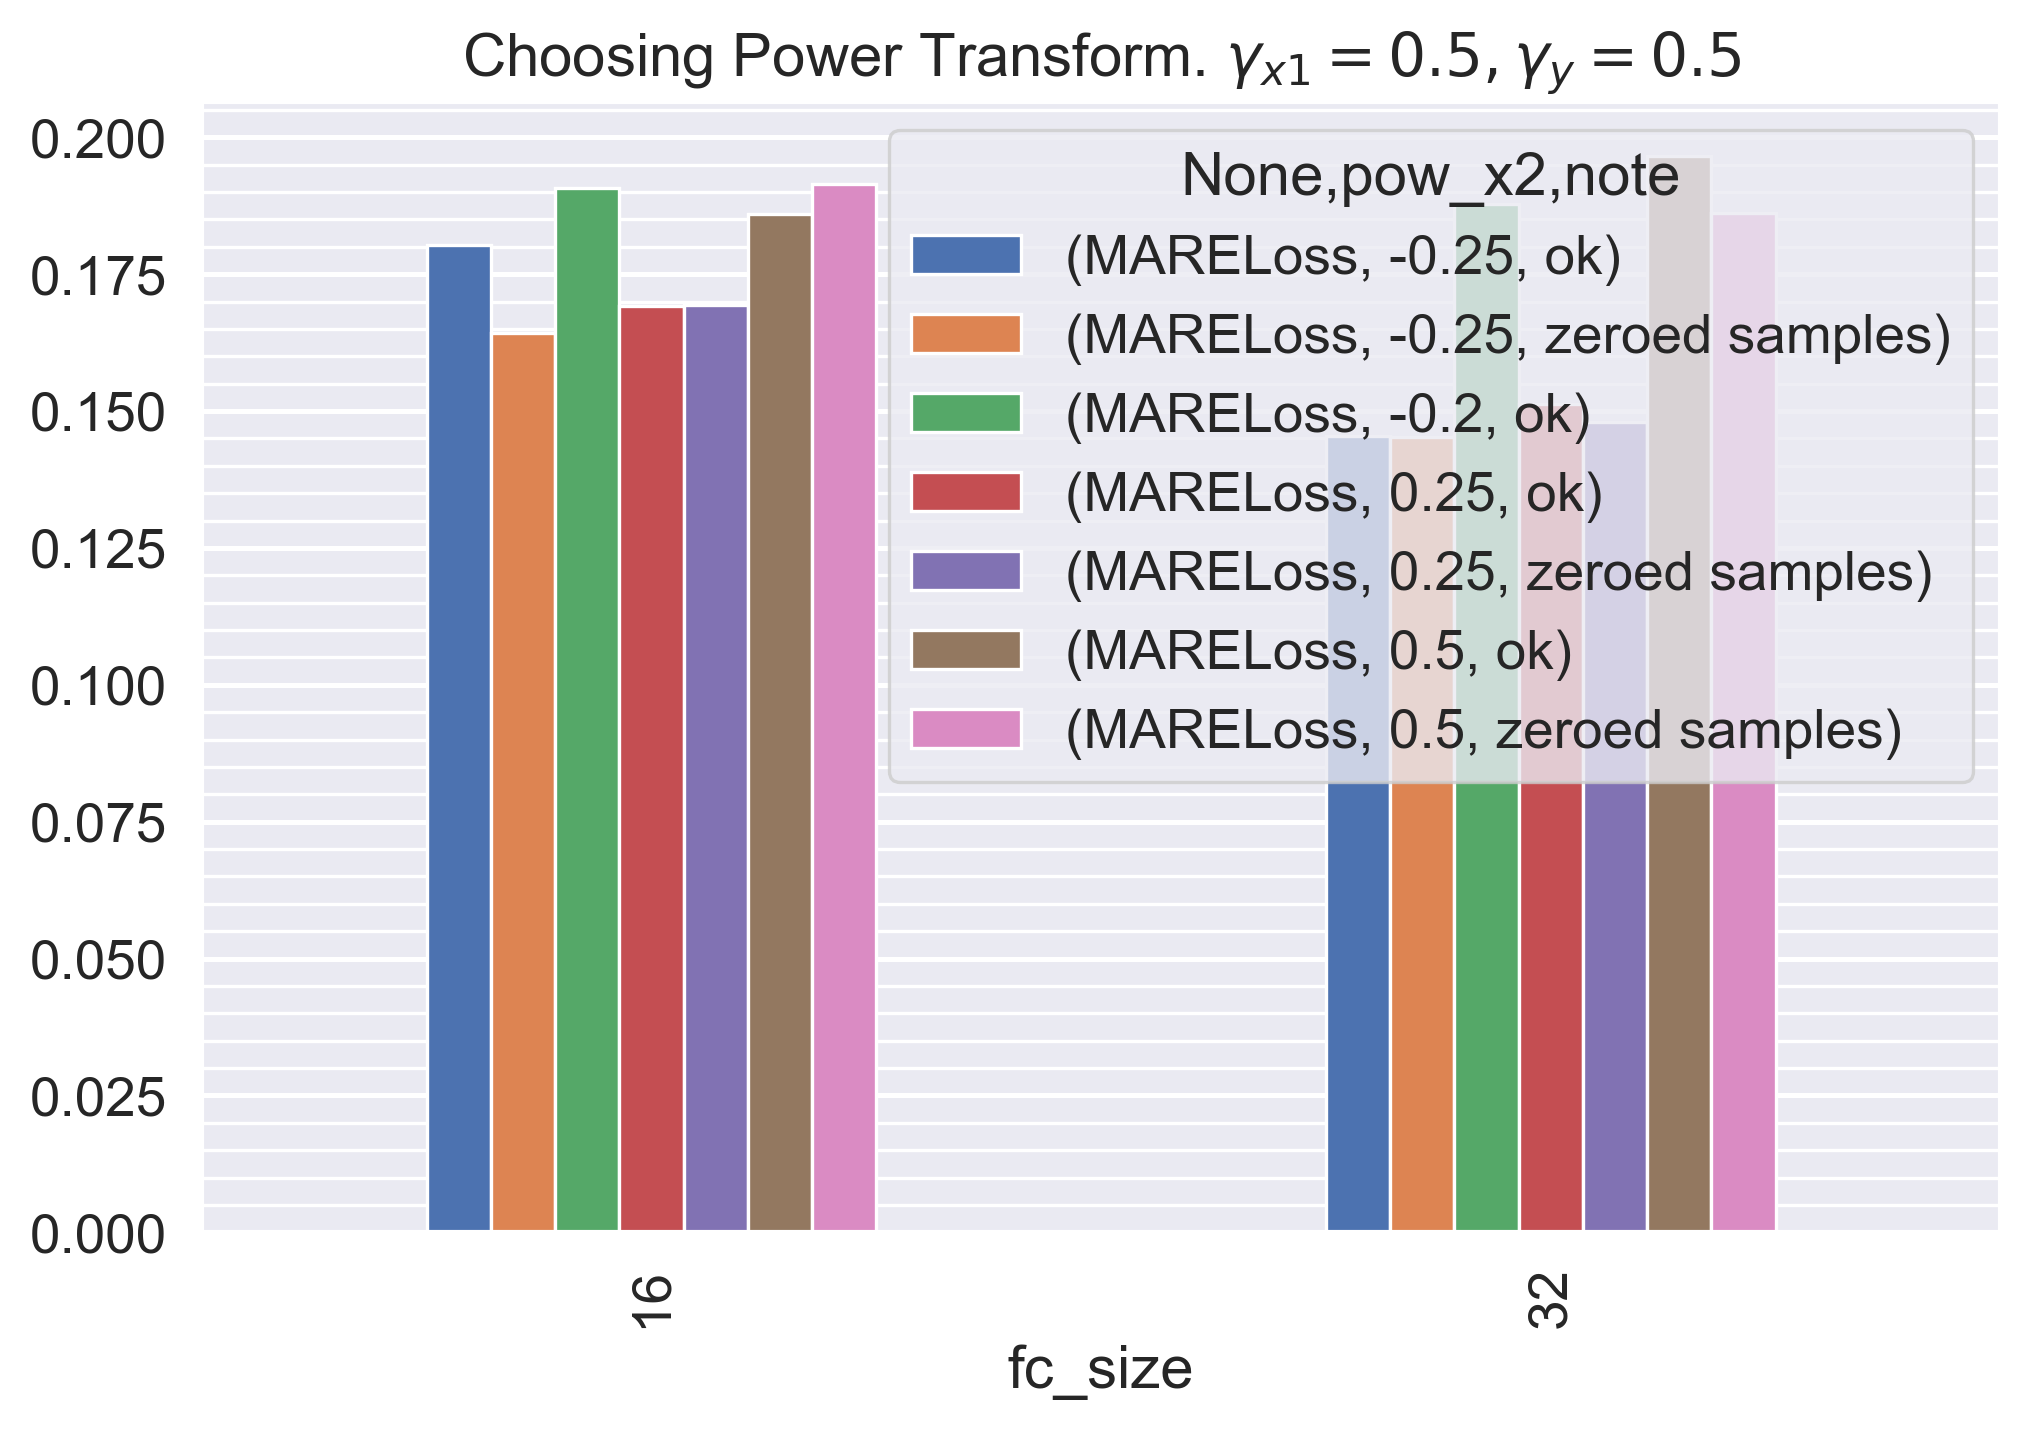

In [106]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))
pd.pivot_table(pow_lidar[(pow_lidar['pow_y']==0.5)][(pow_lidar['pow_x1']==0.5)],
               values=['MARELoss'],
               columns= ['pow_x2','note'],
               index=['fc_size'],
               aggfunc=np.mean).\
    plot(kind='bar',ax =ax, title=r'Choosing Power Transform. $\gamma_{x1}=0.5 , \gamma_y=0.5$')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()

## 3. Type of source
1. X: range_corr(lidar), attbsc(molecular). Y:LC
> use_power = True
> use_bg = False
> source = all
> dnorm = True
> lr > 0.0001

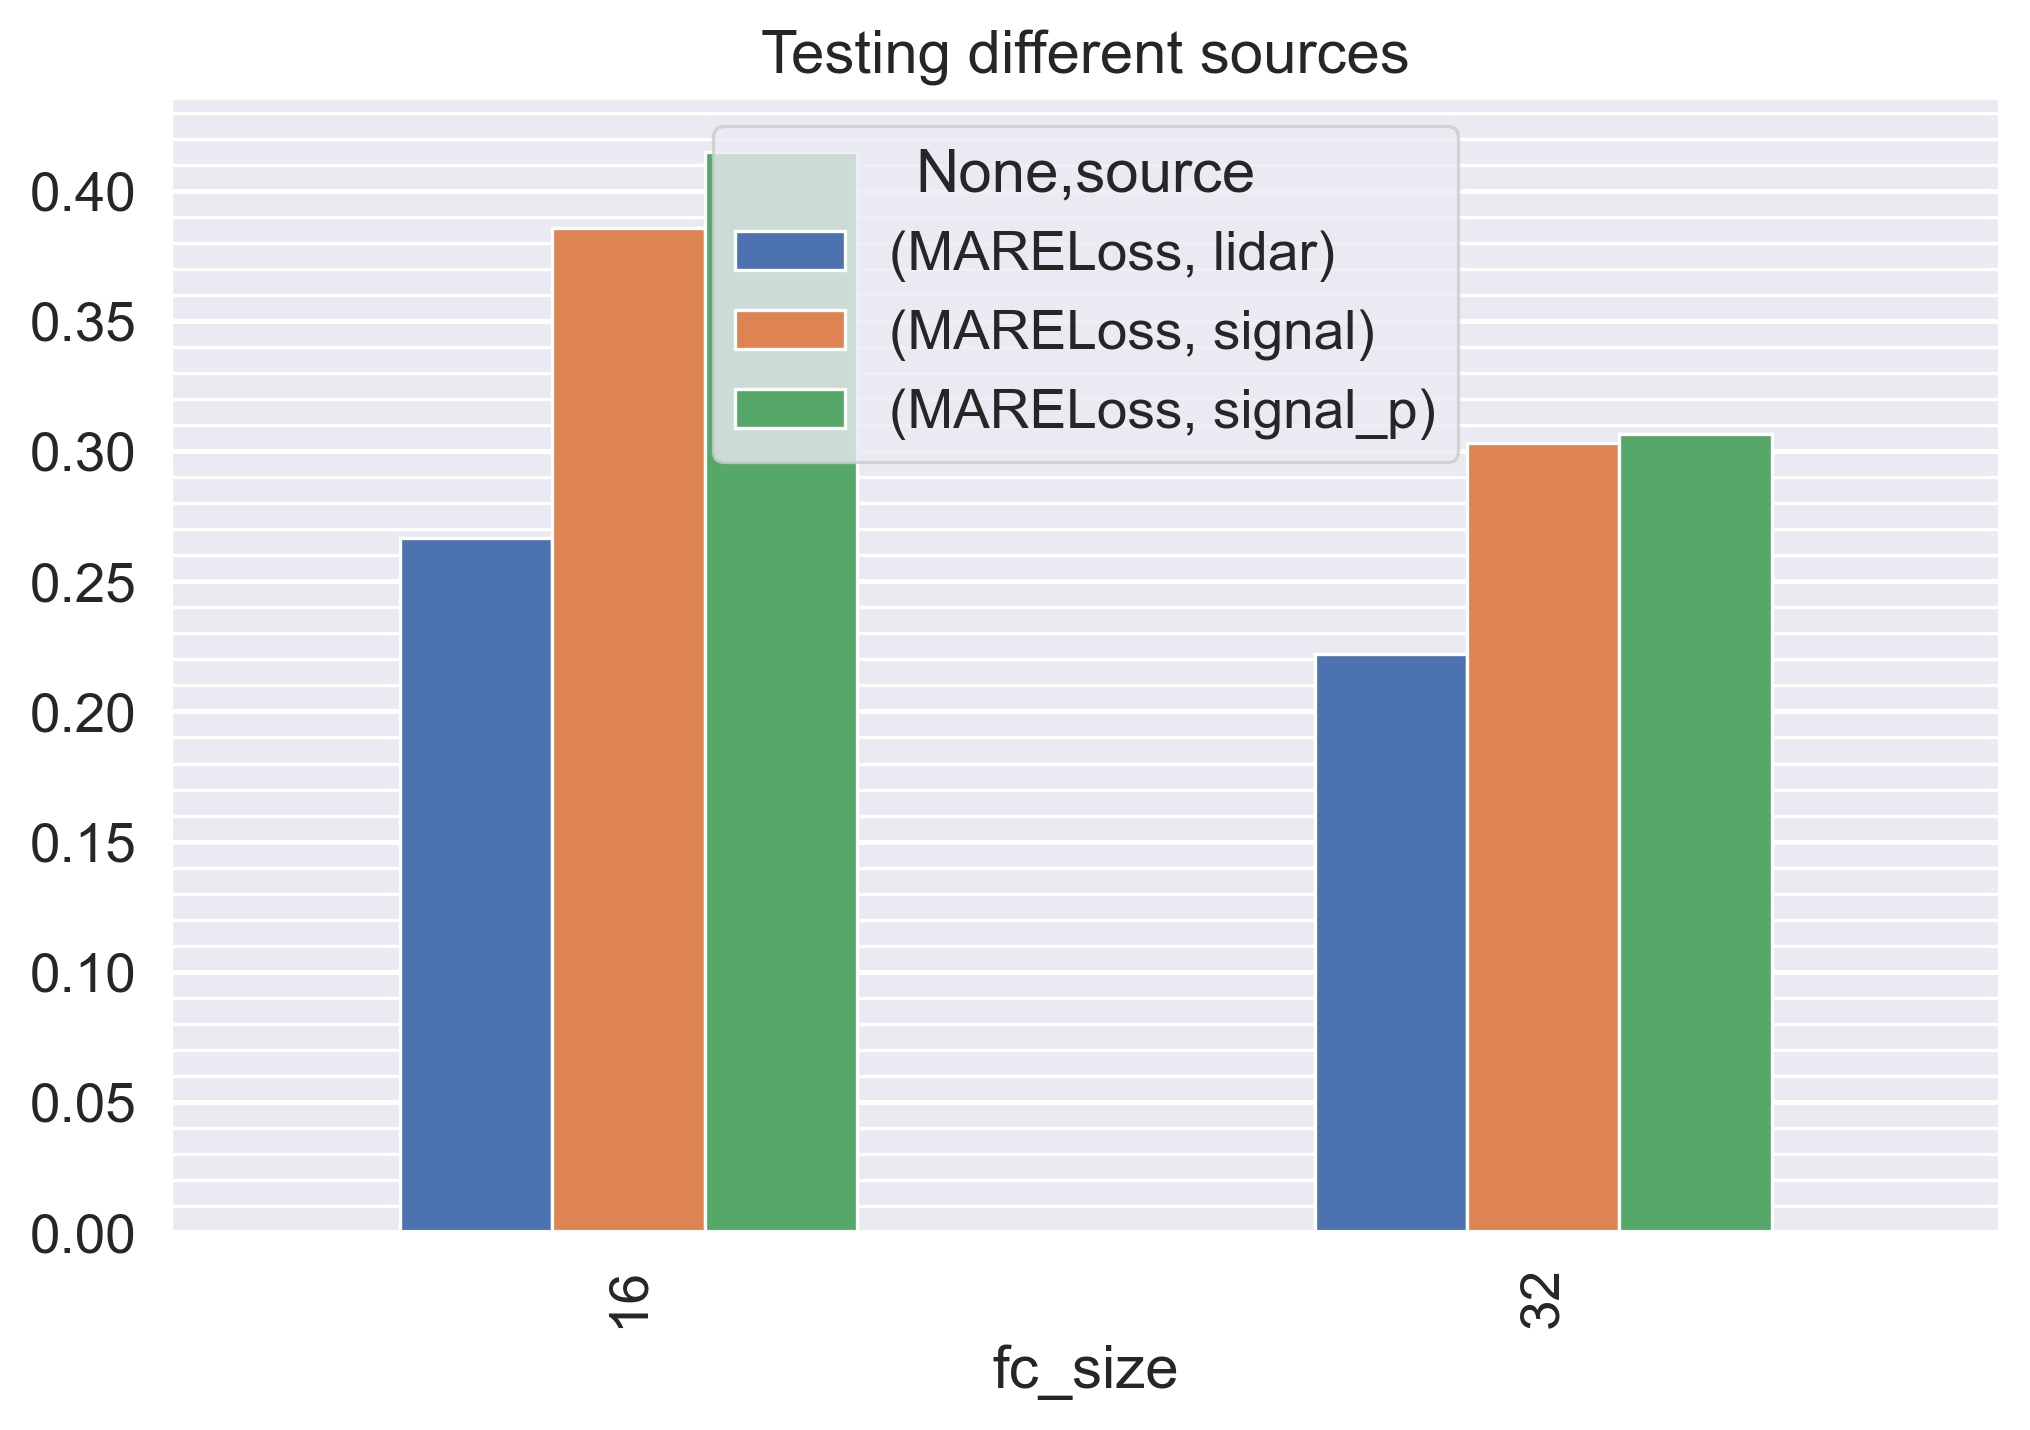

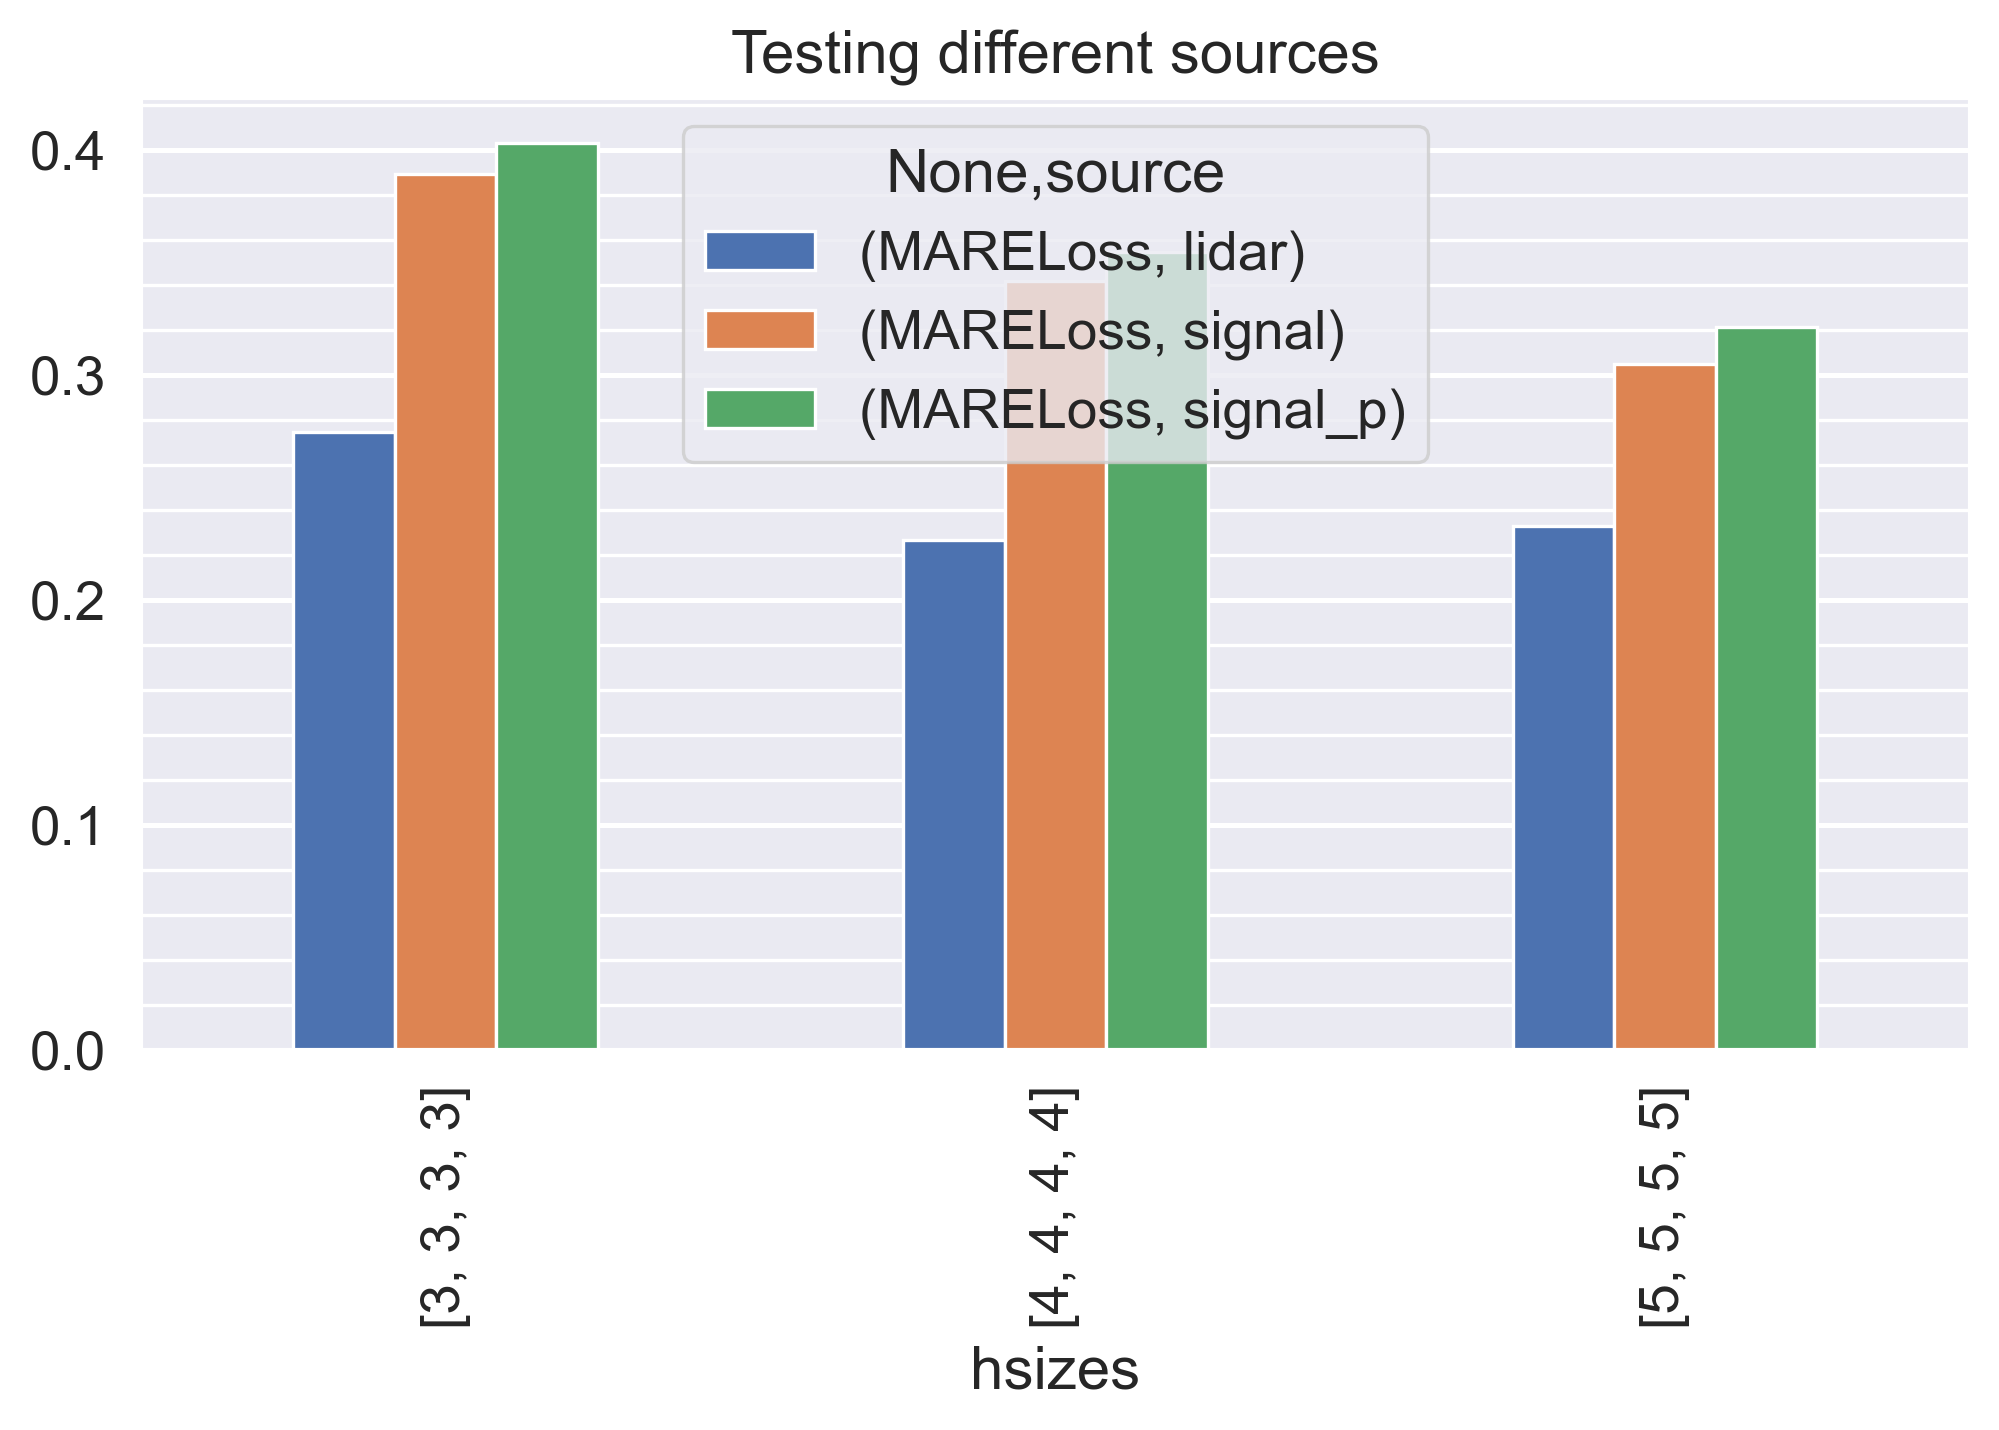

In [107]:
sources_res = analyse_results[(analyse_results.use_power &
                             ~analyse_results.dnorm)]
sources_res[sources_res.use_bg==False]
sources_res = analyse_results[analyse_results.lr==0.001]
sources_res = analyse_results[analyse_results.fc_size>4]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))
pd.pivot_table(sources_res,
               values=['MARELoss'],
               columns= ['source'],
               index=['fc_size'],
               aggfunc=np.mean).\
    plot(kind='bar',ax =ax, title='Testing different sources')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))
pd.pivot_table(sources_res,
               values=['MARELoss'],
               columns= ['source'],
               index=['hsizes'],
               aggfunc=np.mean).\
    plot(kind='bar',ax =ax, title='Testing different sources')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()

## 3. Adding
1. X: range_corr(lidar), attbsc(molecular). Y:LC
> use_power = True
> fc_size>4
> source = lidar
> dnorm = False
> lr==0.001
> pow_y = 0.5

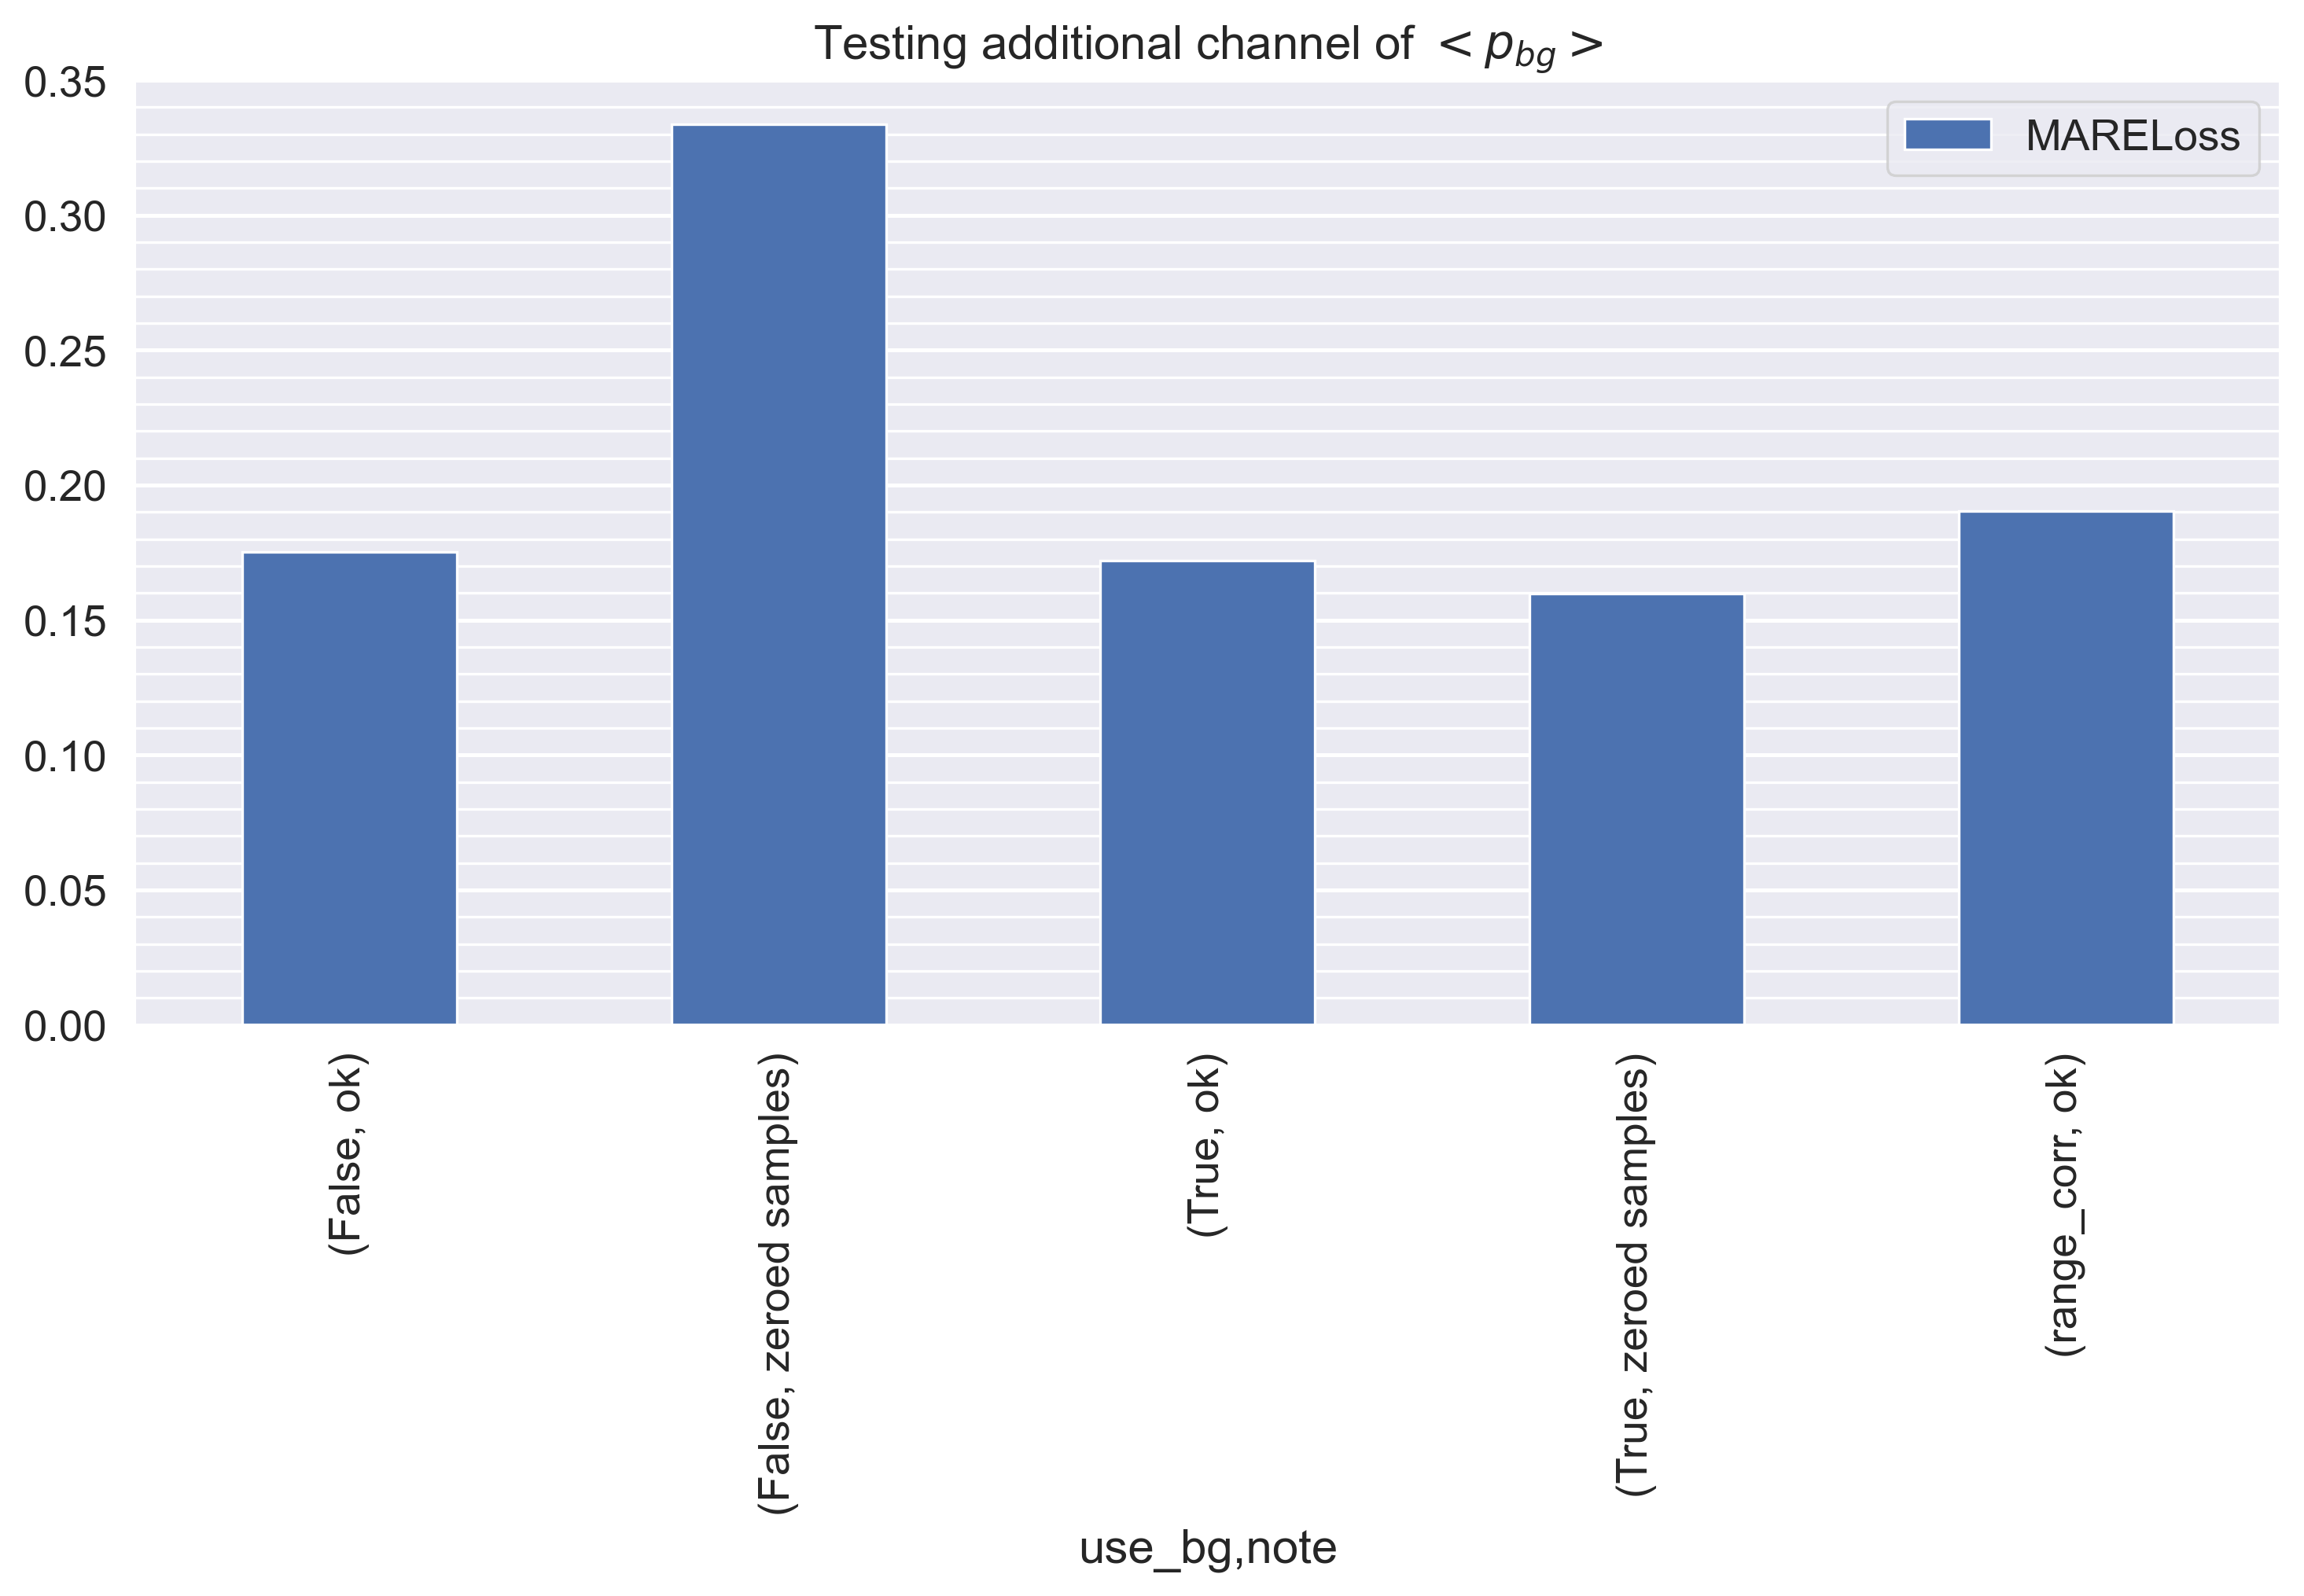

In [108]:
bg_res = analyse_results[analyse_results.source=='lidar']
bg_res = bg_res[bg_res.use_power &
                ~bg_res.dnorm ]
bg_res = bg_res[bg_res.lr==0.001]
bg_res = bg_res[bg_res.fc_size>4]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
pd.pivot_table(bg_res,
               values=['MARELoss'],
               #columns= ['pow_x2'],#'pow_x'],
               index=['use_bg','note'],
               aggfunc=np.mean).\
    plot(kind='bar',ax =ax, title=r'Testing additional channel of $<p_{bg}> $')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()

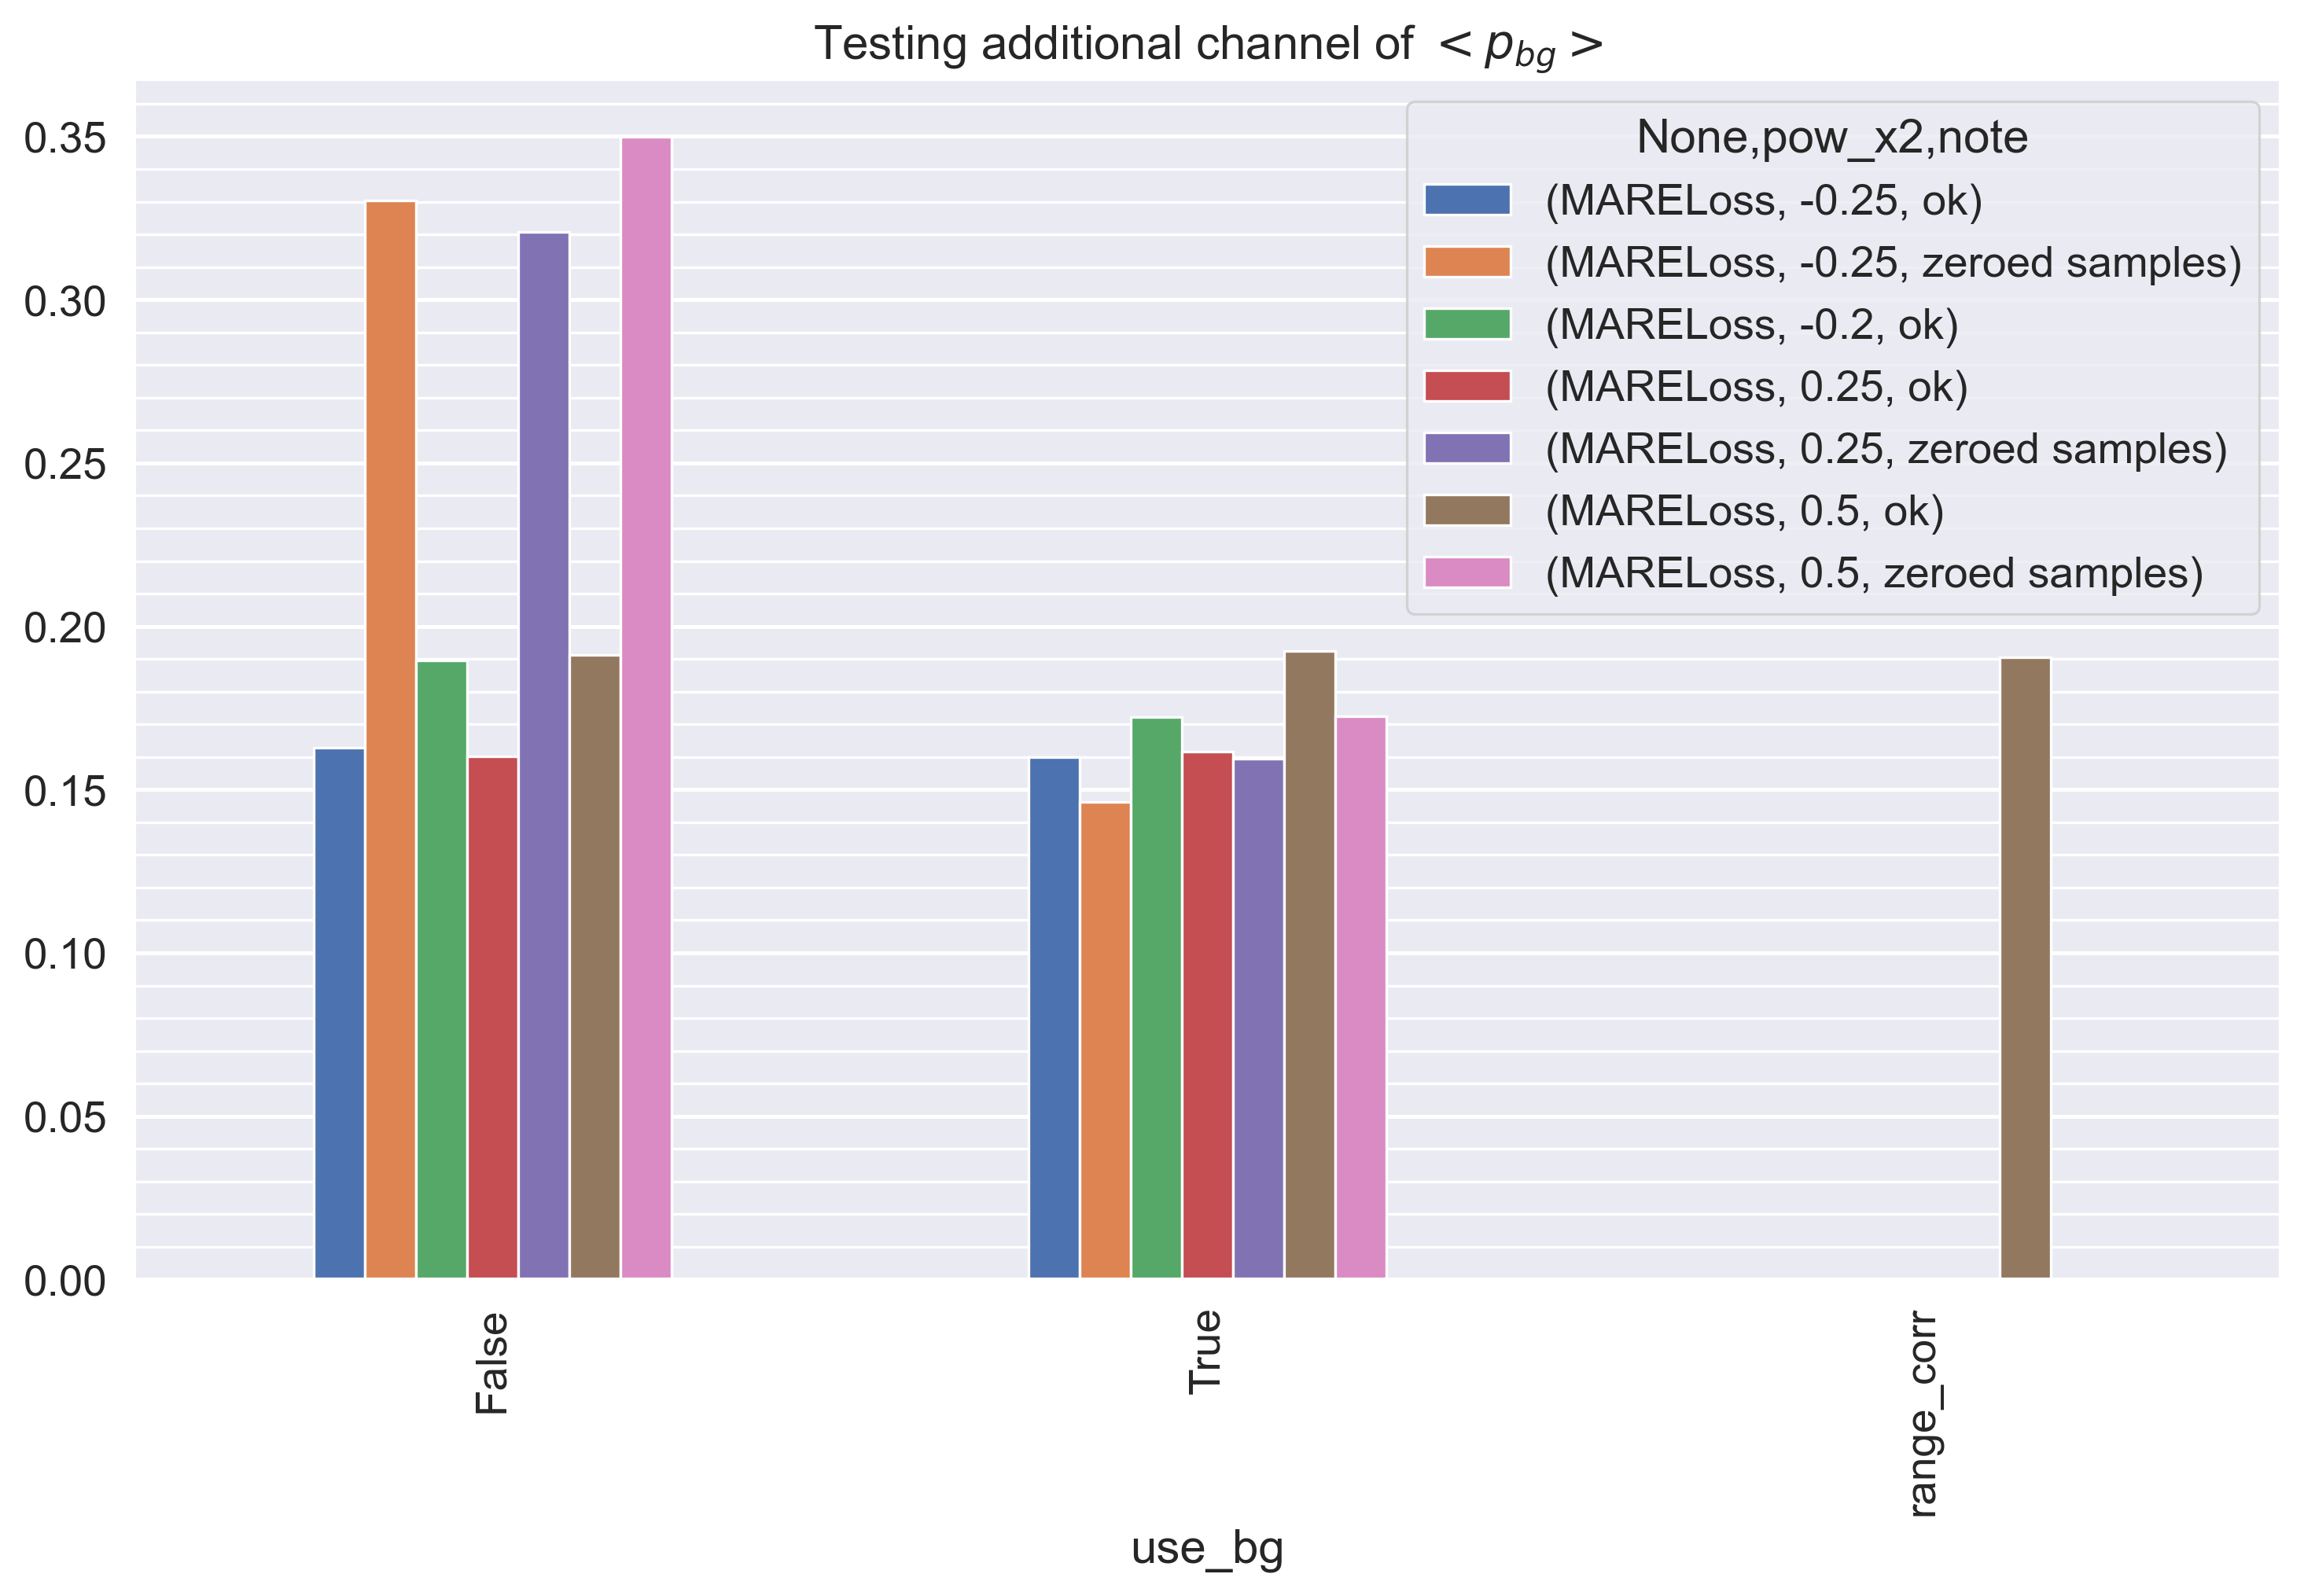

In [109]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
pd.pivot_table(bg_res,
               values=['MARELoss'],
               columns= ['pow_x2','note'],
               index=['use_bg'],
               aggfunc=np.mean).\
    plot(kind='bar',ax =ax, title=r'Testing additional channel of $<p_{bg}> $')
plt.tight_layout()

ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.xaxis.grid(False)
plt.show()

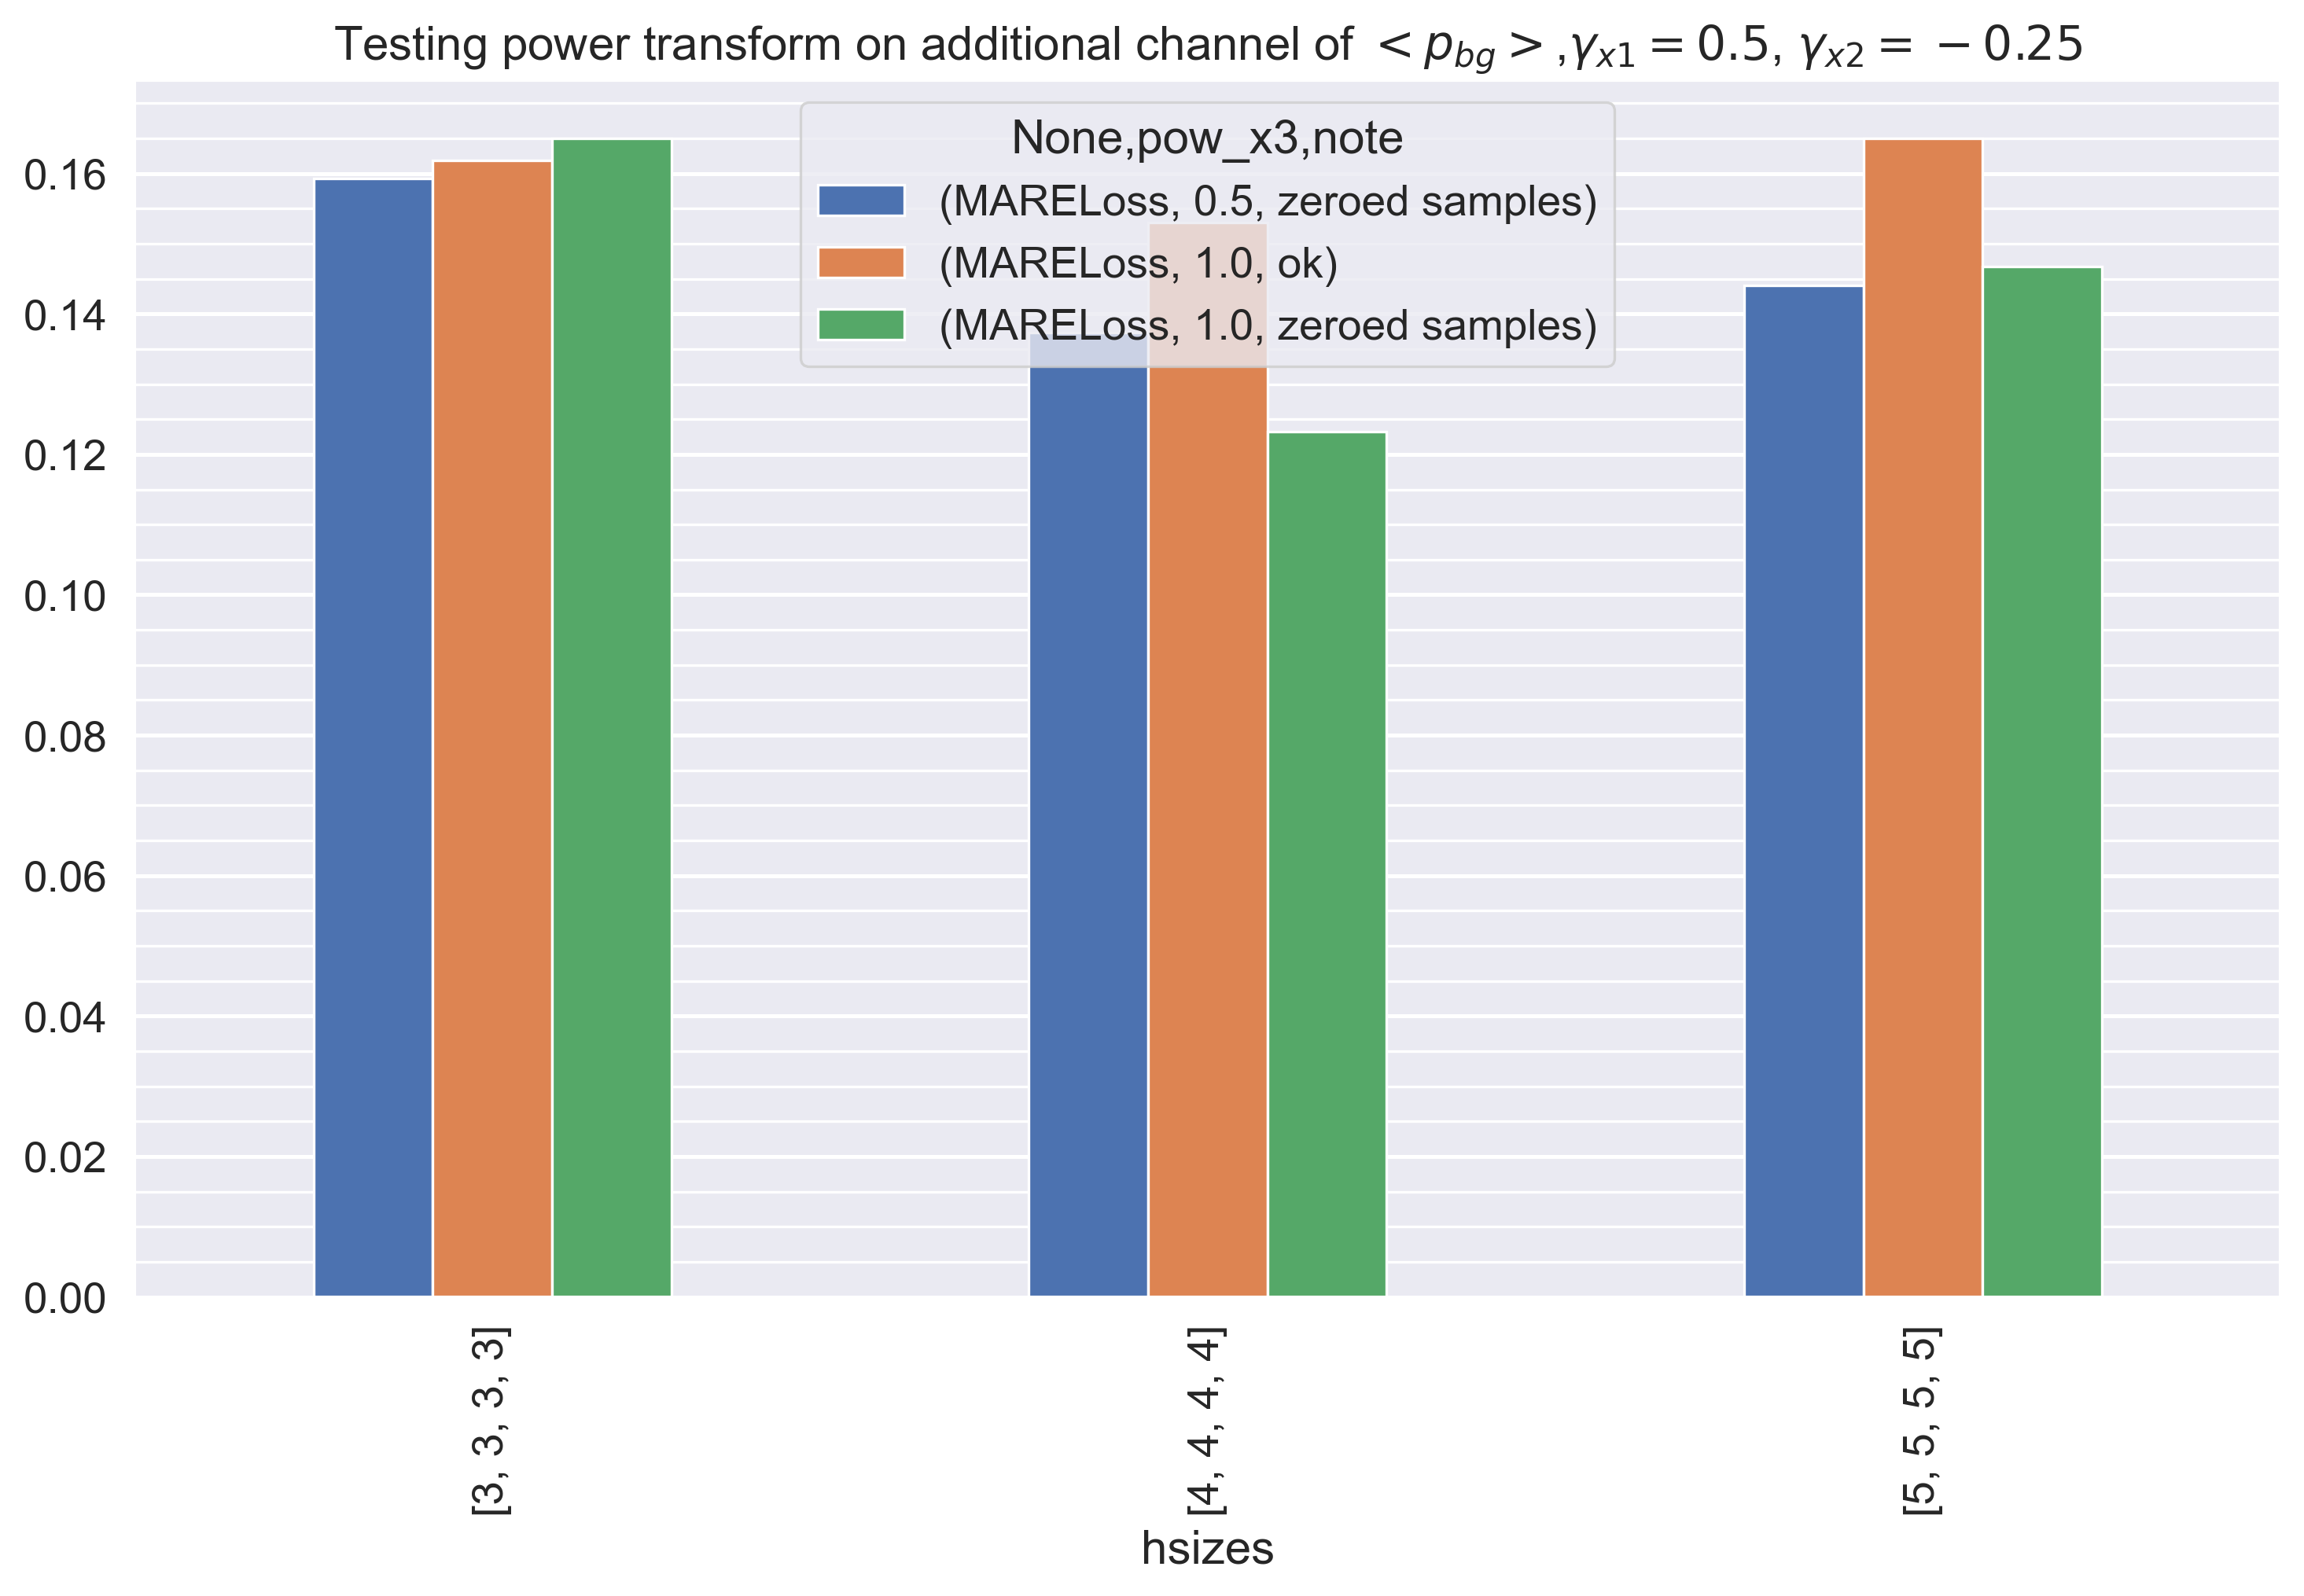

In [110]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
pd.pivot_table(bg_res[bg_res.pow_x2==-0.25],
               values=['MARELoss'],
               columns= ['pow_x3','note'],#'fc_size'],
               index=['hsizes'],
               aggfunc=np.mean).\
    plot(kind='bar',ax =ax, title=r'Testing power transform on additional channel of $<p_{bg}>$,$\gamma_{x1}=0.5$, $\gamma_{x2}=-0.25$')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()

<ipython-input-111-29ea939e37dd>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(bg_res[bg_res.use_bg!=False][bg_res.pow_x3==1.0][bg_res.pow_x2==-0.25],
<ipython-input-111-29ea939e37dd>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pd.pivot_table(bg_res[bg_res.use_bg!=False][bg_res.pow_x3==1.0][bg_res.pow_x2==-0.25],


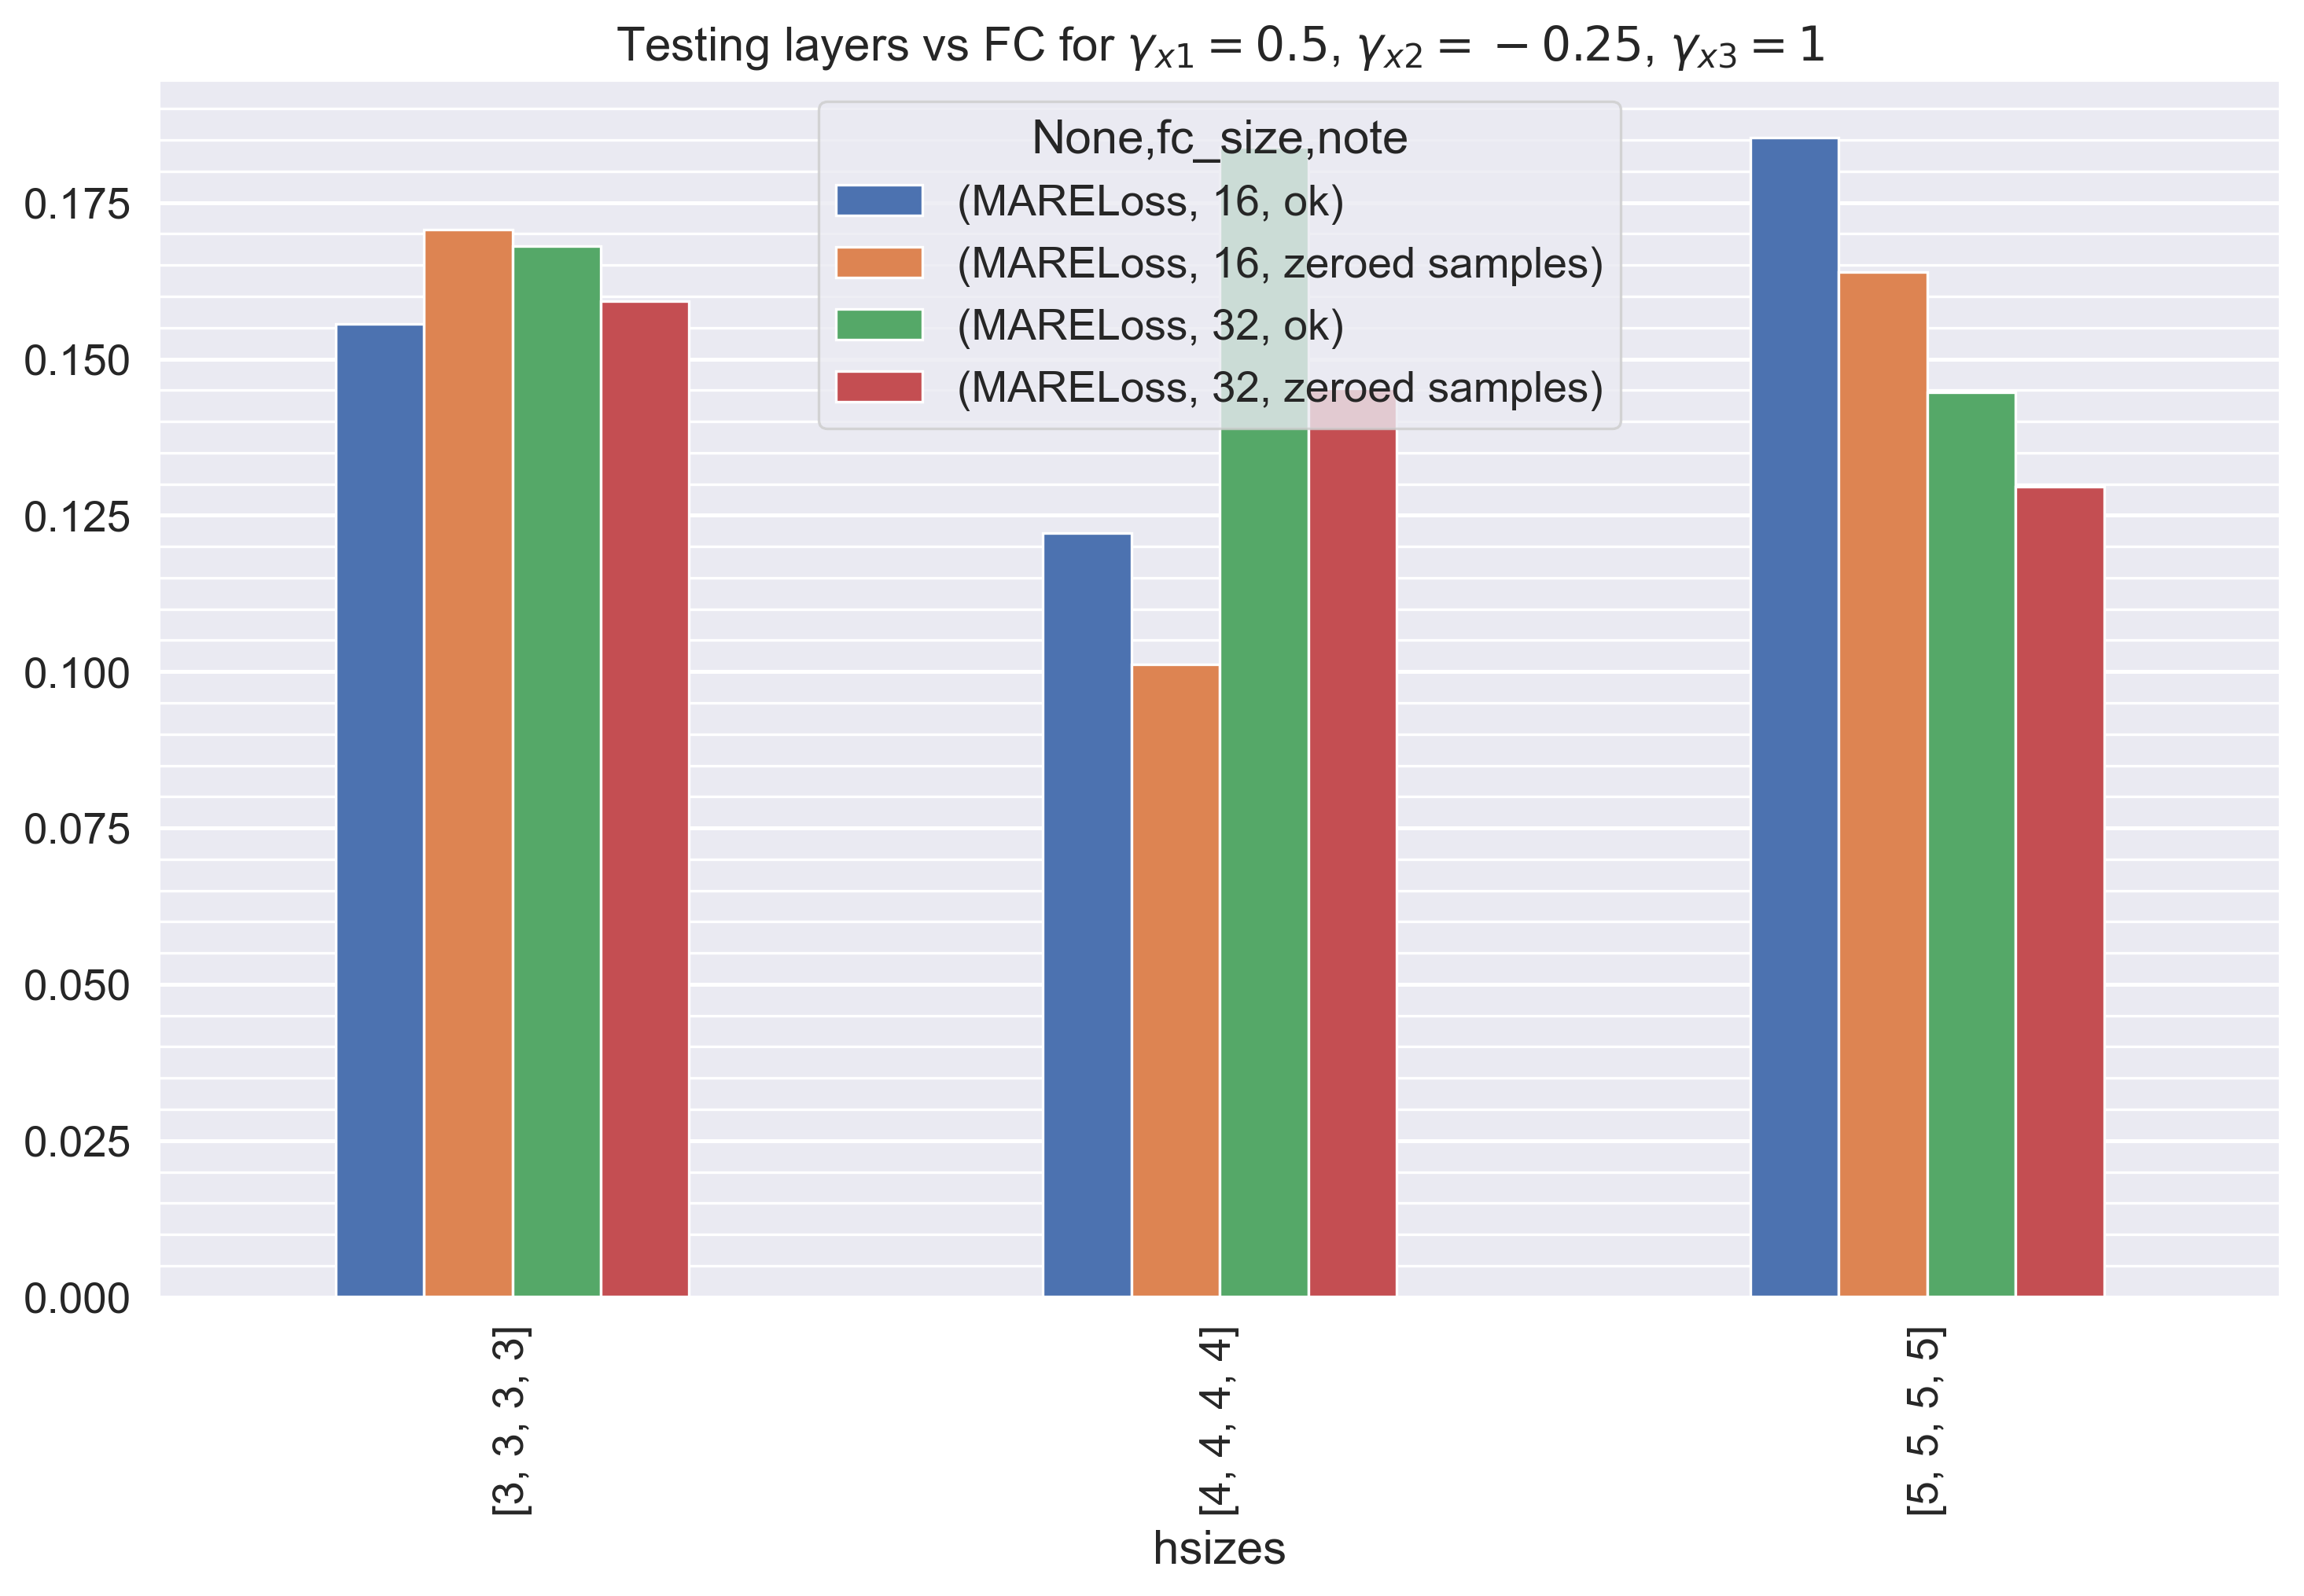

In [111]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
pd.pivot_table(bg_res[bg_res.use_bg!=False][bg_res.pow_x3==1.0][bg_res.pow_x2==-0.25],
               values=['MARELoss'],
               columns= ['fc_size','note'],
               index=['hsizes'],
               aggfunc=np.min).\
    plot(kind='bar',ax =ax, title=r'Testing layers vs FC for $\gamma_{x1}=0.5$, $\gamma_{x2}=-0.25$, $\gamma_{x3}=1$')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()

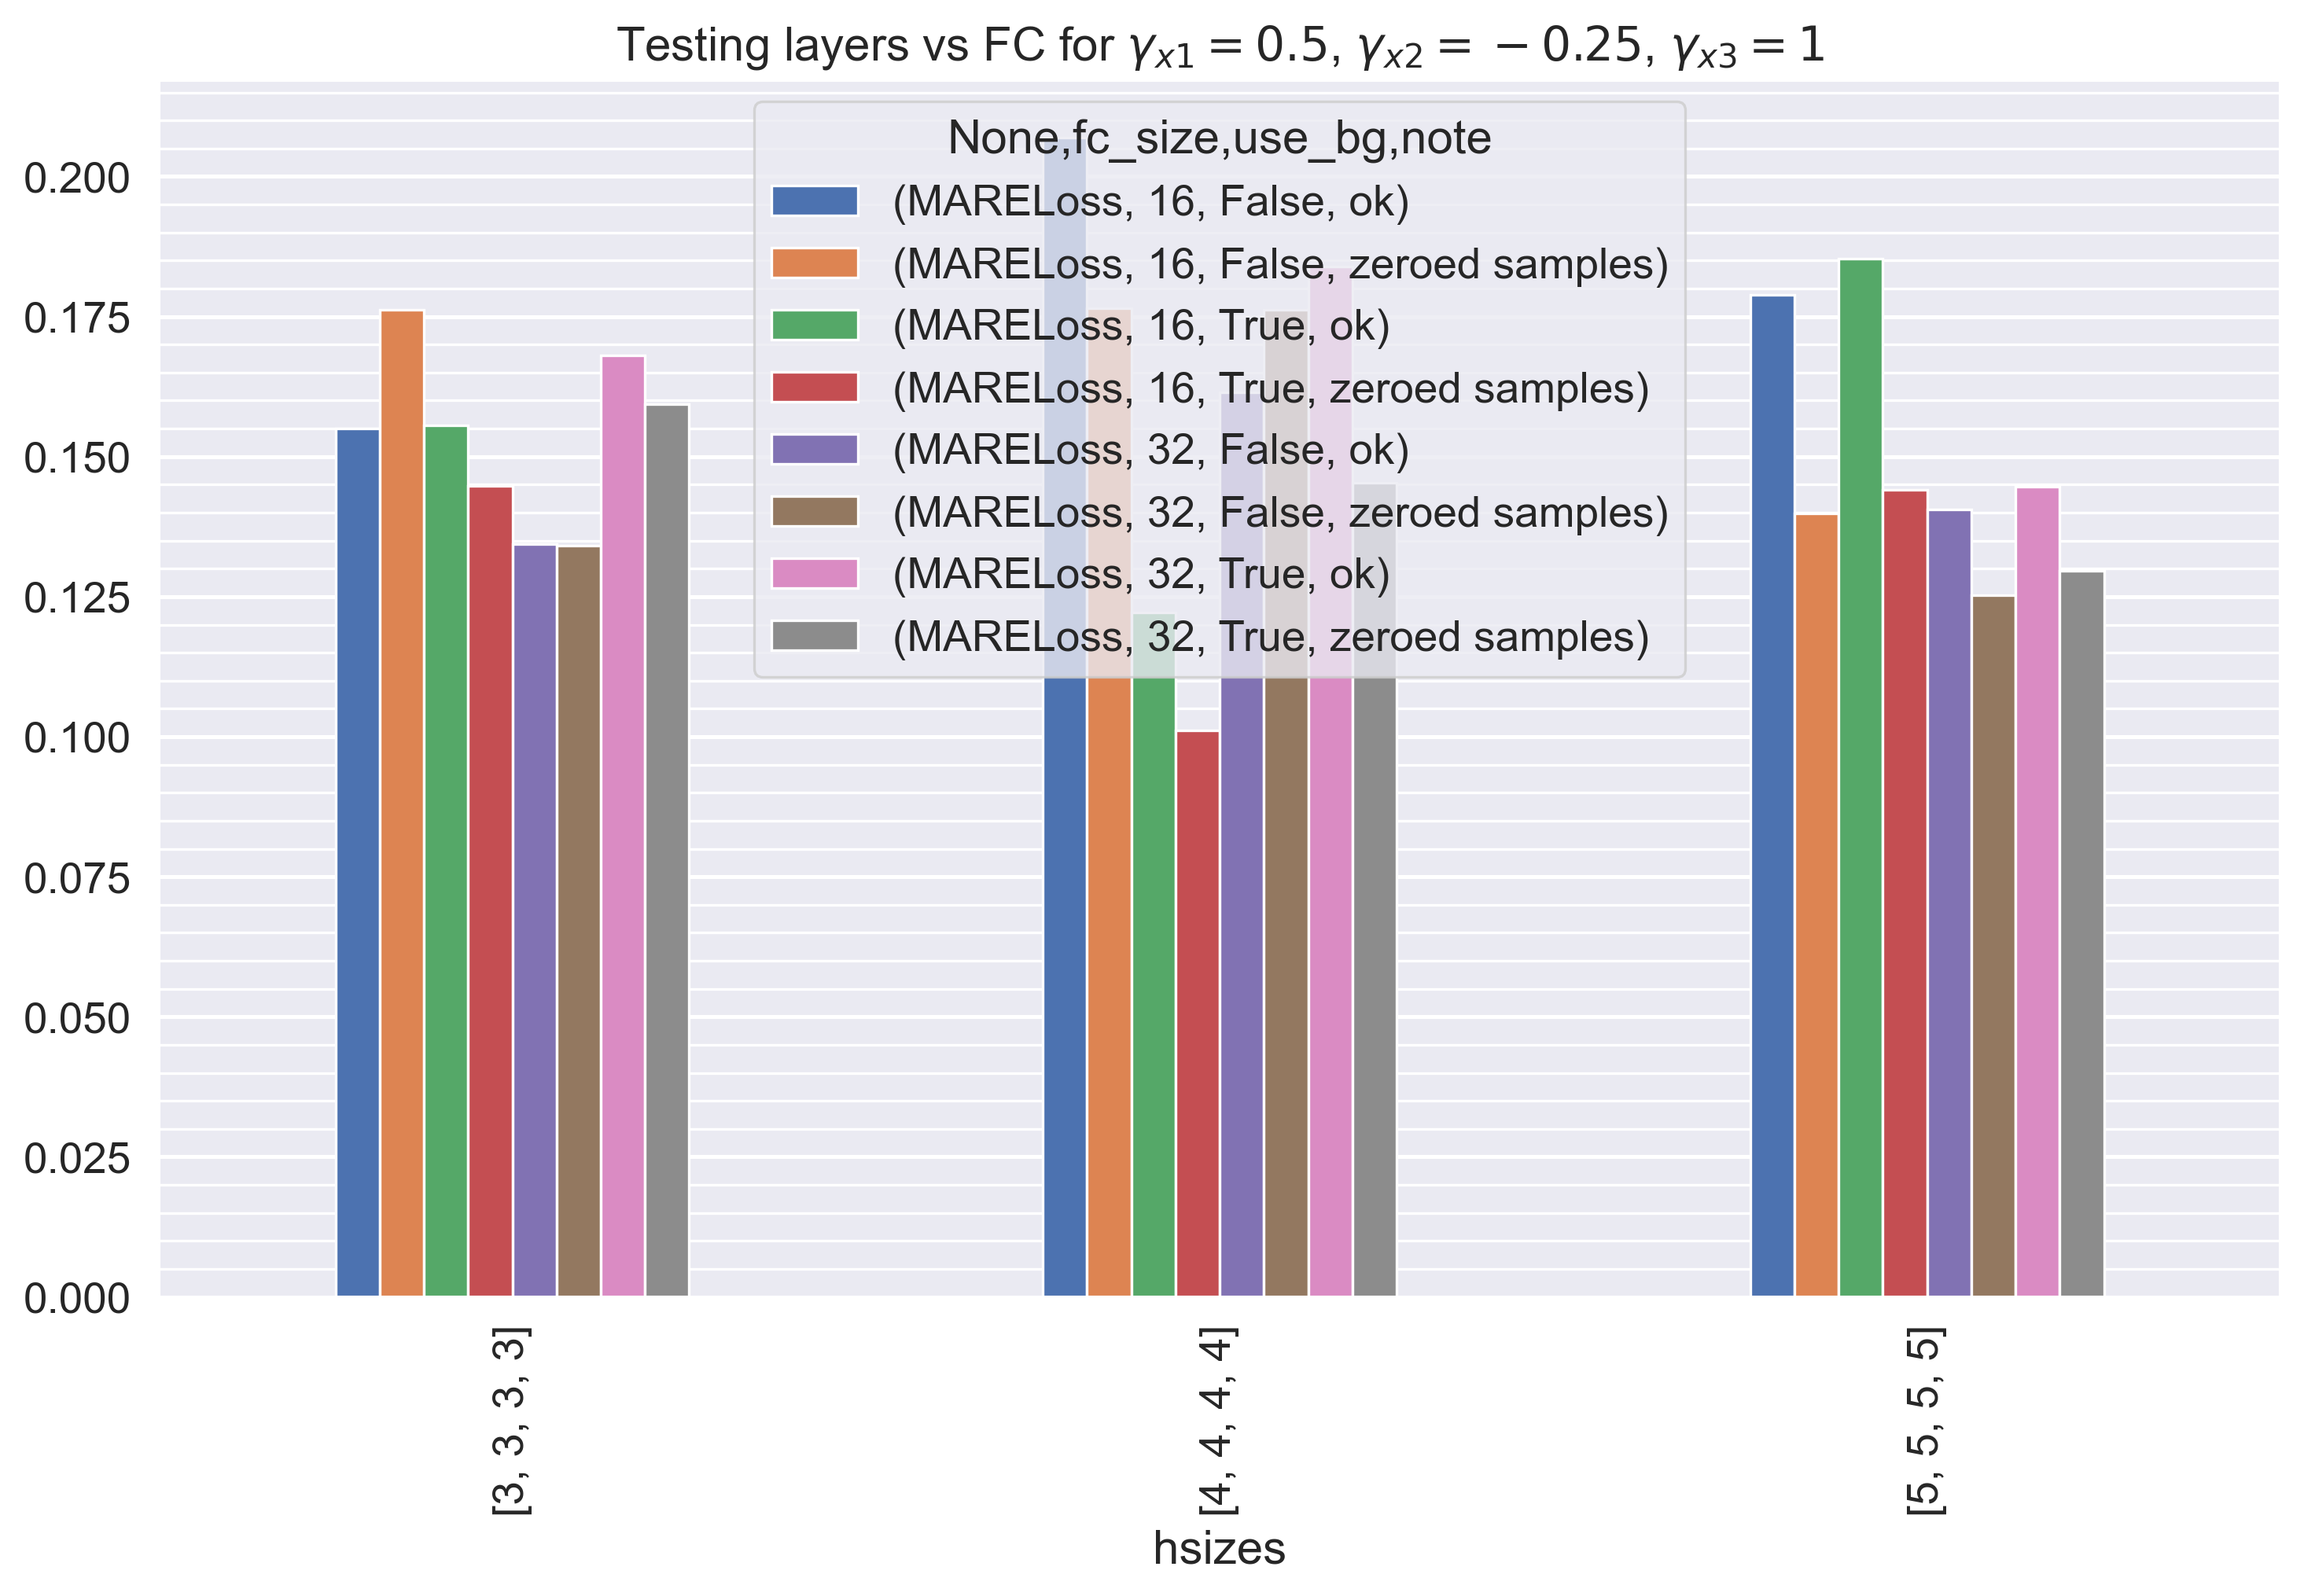

In [112]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
pd.pivot_table(bg_res[bg_res.pow_x2==-0.25],
               values=['MARELoss'],
               columns= ['fc_size','use_bg','note'],
               index=['hsizes'],
               aggfunc=np.min).\
    plot(kind='bar',ax =ax, title=r'Testing layers vs FC for $\gamma_{x1}=0.5$, $\gamma_{x2}=-0.25$, $\gamma_{x3}=1$')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.xaxis.grid(False)
plt.tight_layout()
plt.show()


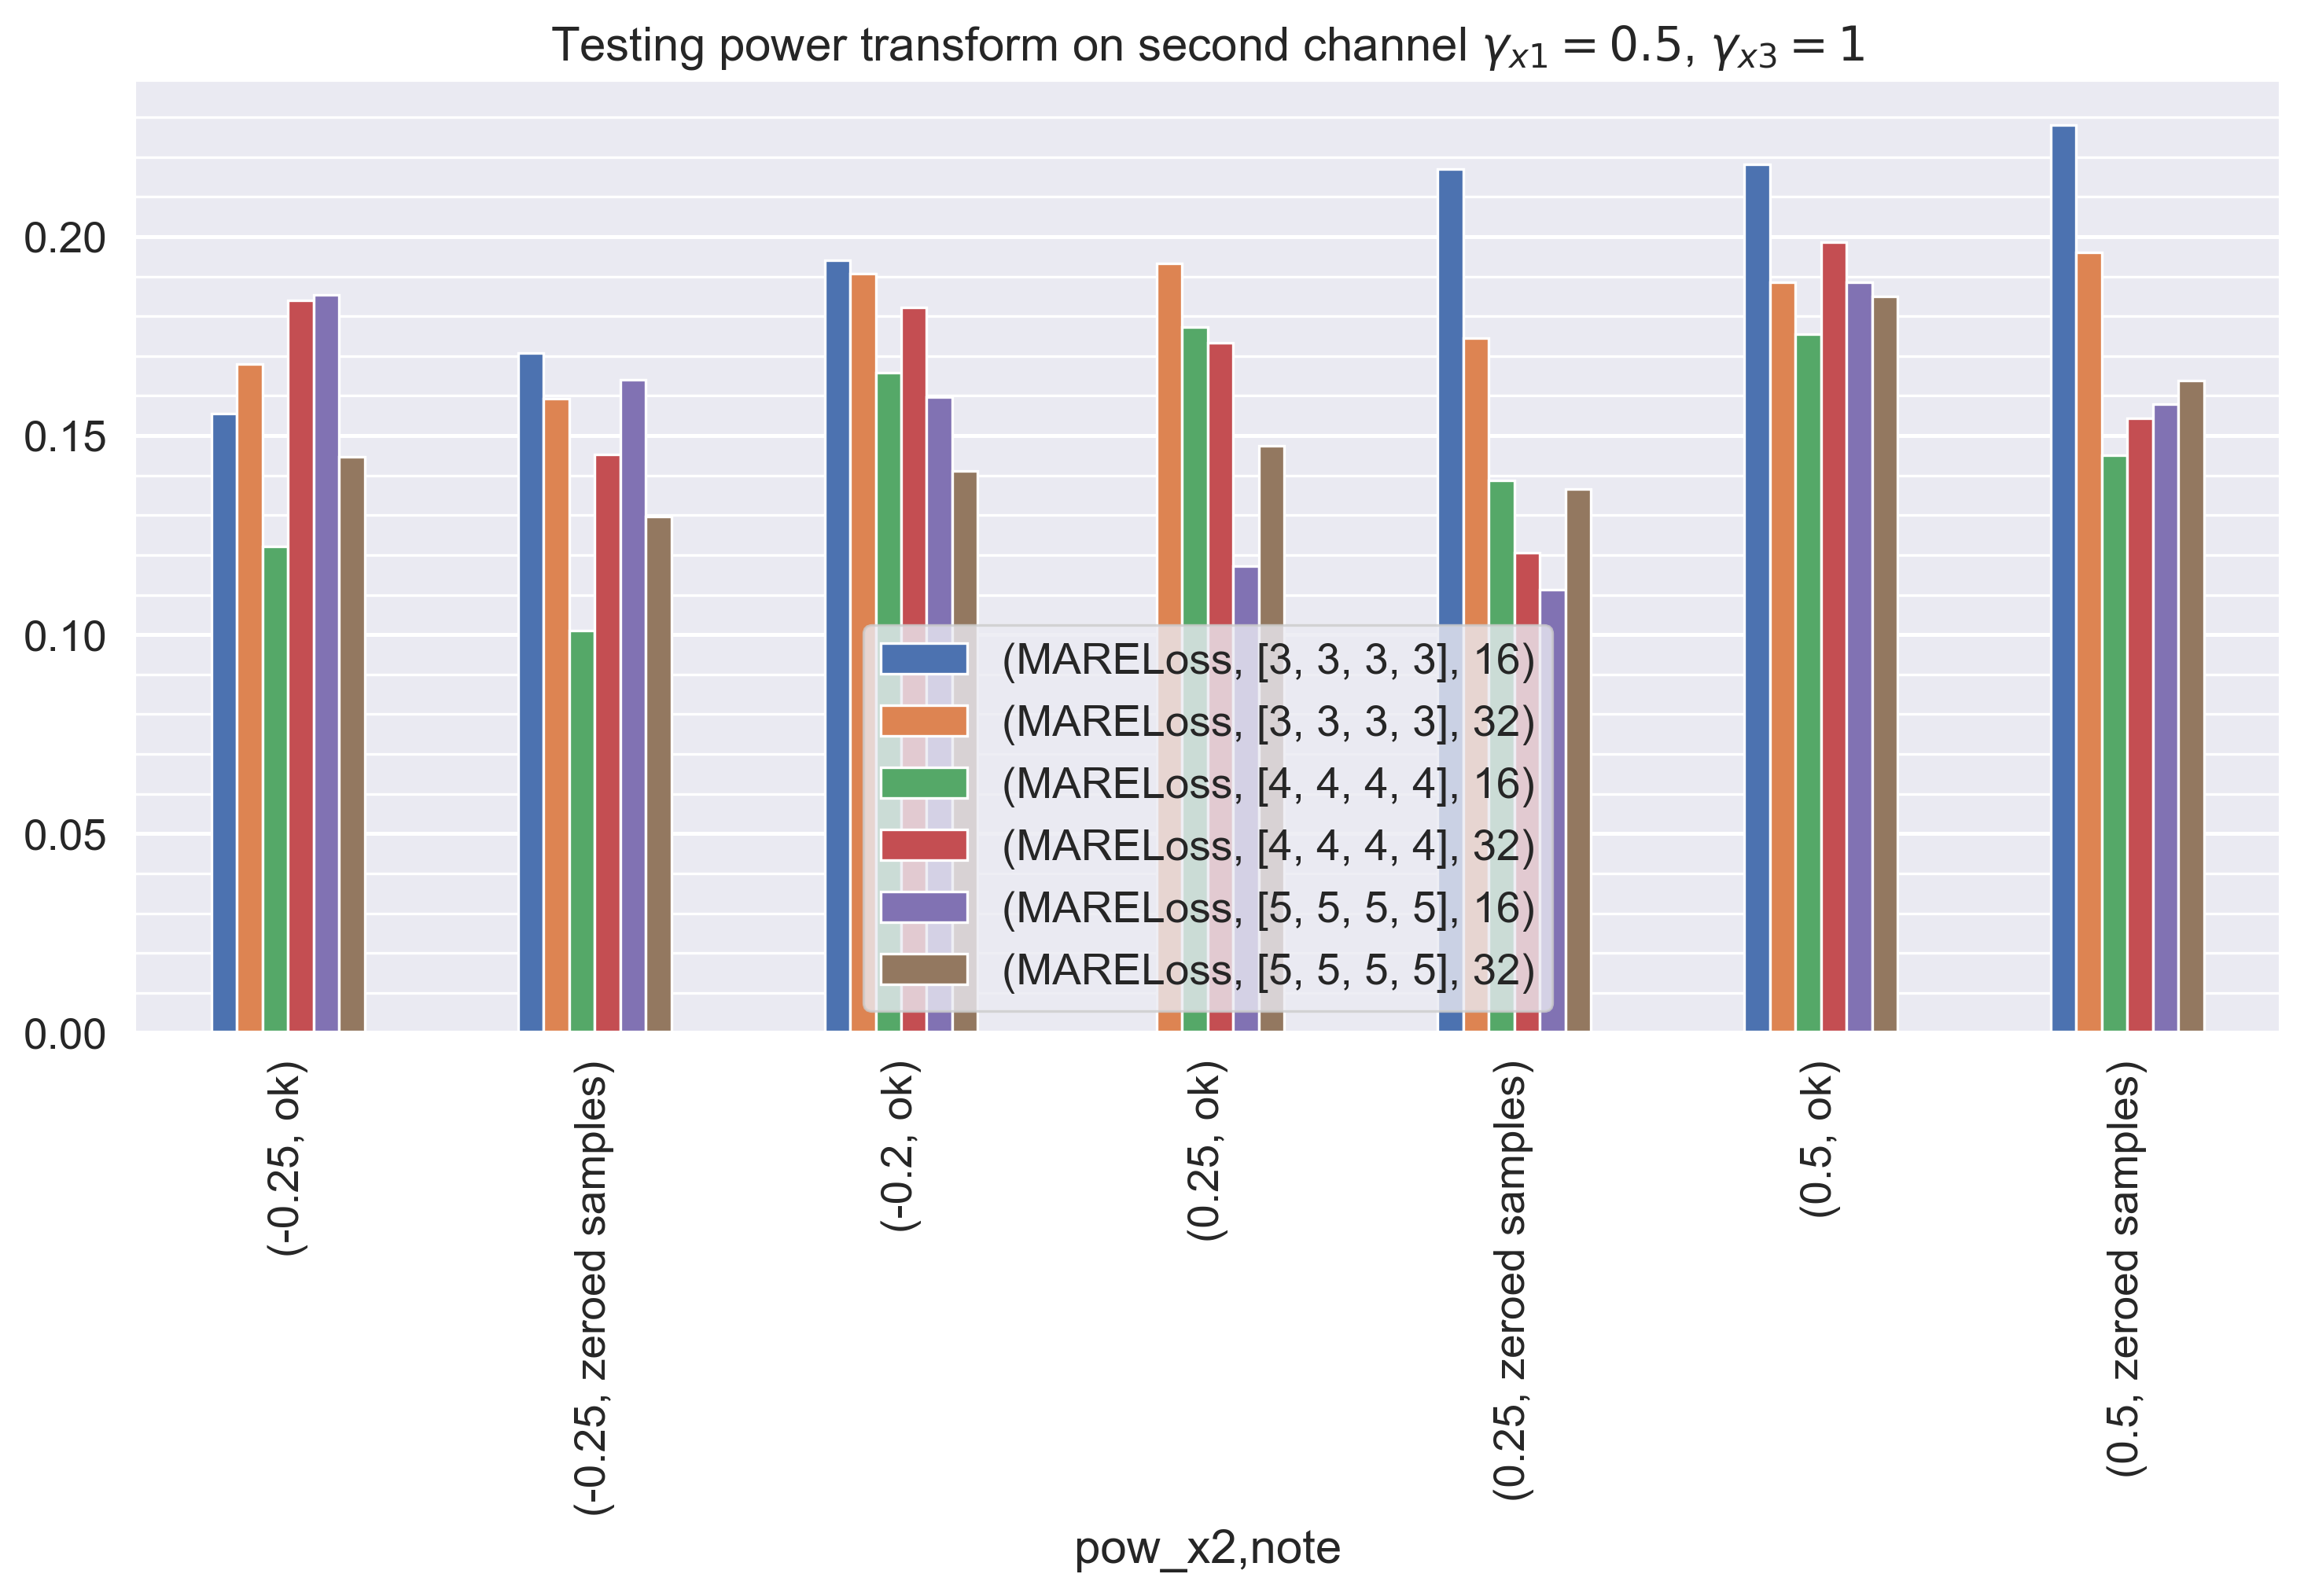

In [113]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
pd.pivot_table(bg_res[bg_res.pow_x3==1.0],
               values=['MARELoss'],
               columns= ['hsizes','fc_size'],
               index=['pow_x2','note'],
               aggfunc=np.mean).\
    plot(kind='bar',ax =ax, title=r'Testing power transform on second channel $\gamma_{x1}=0.5$, $\gamma_{x3}=1$')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.xaxis.grid(False)
plt.legend( loc="lower center")
plt.tight_layout()
plt.show()

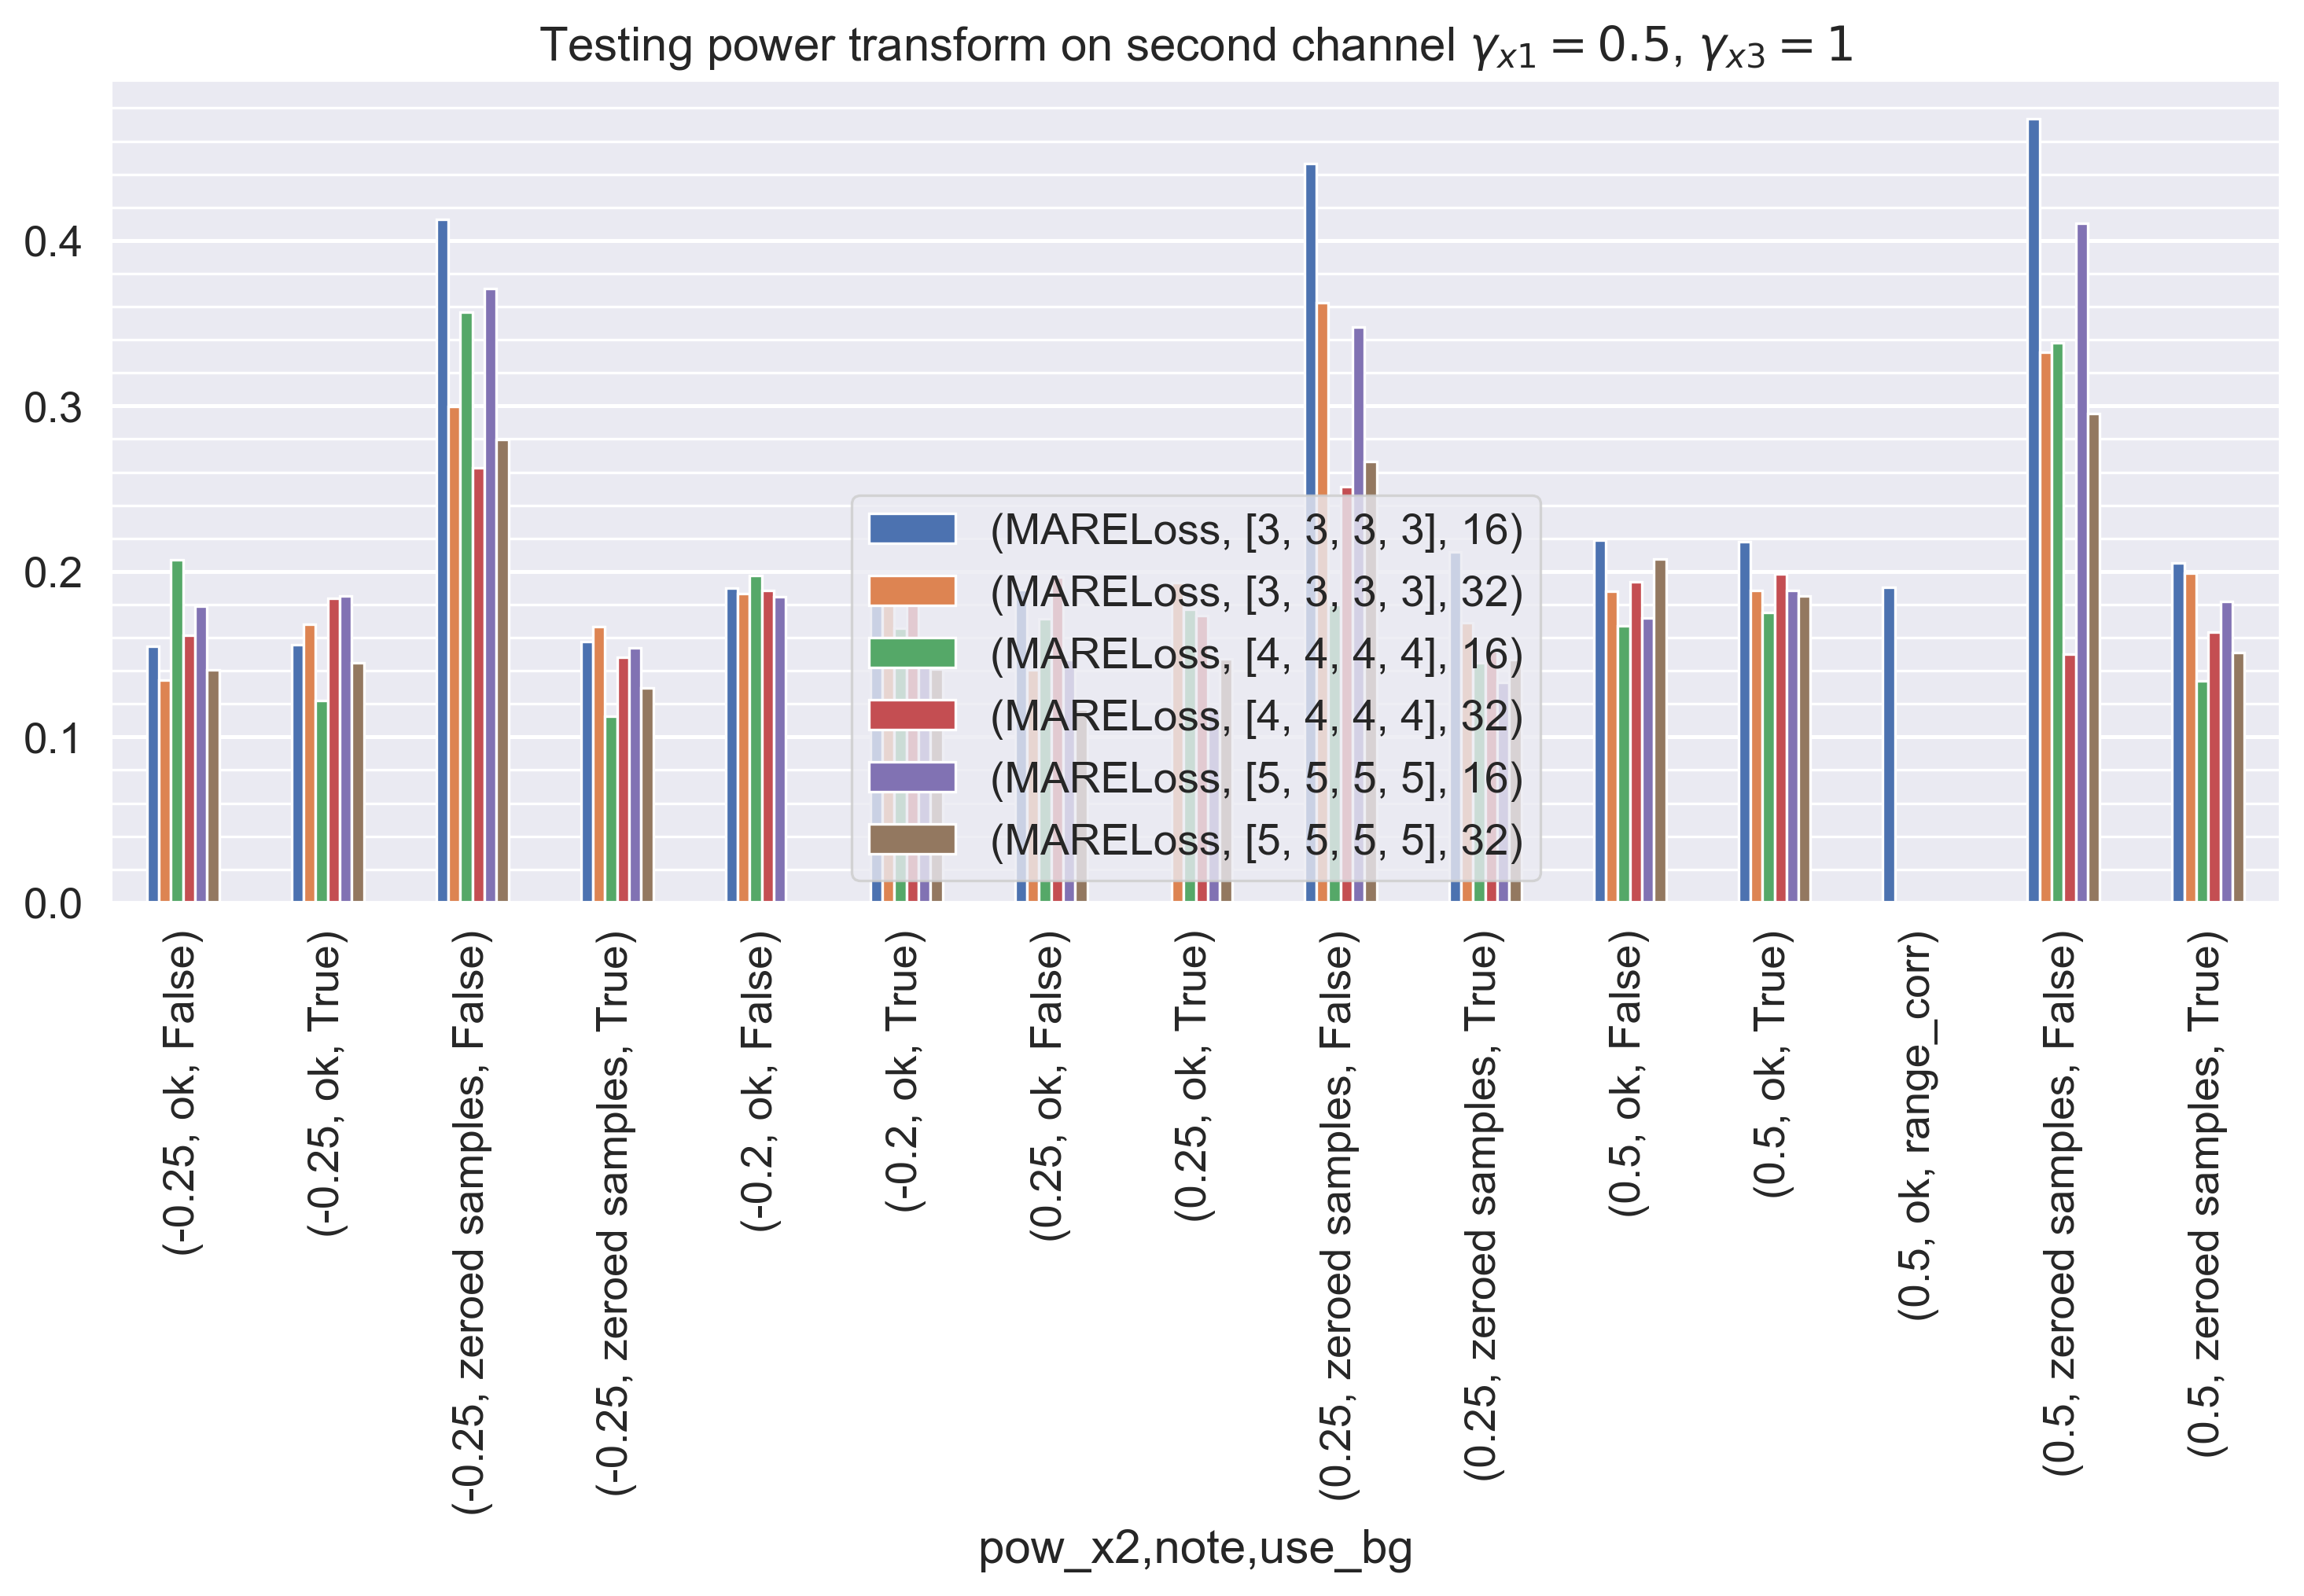

In [114]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
pd.pivot_table(bg_res[bg_res.pow_x1==0.5],
               values=['MARELoss'],
               columns= ['hsizes','fc_size'],
               index=['pow_x2','note','use_bg'],
               aggfunc=np.mean).\
    plot(kind='bar',ax =ax, title=r'Testing power transform on second channel $\gamma_{x1}=0.5$, $\gamma_{x3}=1$')
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='minor', color='w', linewidth=0.8)
ax.grid(b=True, which='major', color='w', linewidth=1.2)
ax.xaxis.grid(False)
plt.legend( loc="lower center")
plt.tight_layout()
plt.show()

# Create a list of chec_points/experiments to restore (run from begining)

In [115]:






# TODO: show figure of different power transform on bg only
# TODO: show r^2 * pbg
# TODO: onclude O(r)
# TODO : a single FC
